---
# <center> <u> TP INFORMATIQUE QUANTIQUE </center> </u>
# <center> <u> POLYTECH PARIS-SACLAY 2024/2025 </center> </u>
    
<i> Océane Koska (Eviden - Laboratoire des Méthodes Formelles, Univeristé Paris Saclay)
    
Contact : oceane.koska@eviden.com, oceanekoska@gmail.com

<u> Objectifs du TP</u> : <br>
- manipuler des portes quantiques et des circuits quantiques, <br>
- apprendre à utiliser un logiciel de calcul quantique (ici Qiskit), <br>
- développer des algorithmes pour générer des circuits et algorithmes quantiques, <br>
- gagner en intuition sur le fonctionnement et la conception des algorithmes quantiques. <br>   

<u> Plan du TP</u> : <br>
1. les pré-requis pour le TP (packages, fonctions essentielles, etc),
2. introduction à Qiskit, sa syntaxe et premiers exemples de circuits,
3. implémentations de premières expériences quantiques,
3. implémentations d'algorithmes quantiques plus complexes : Deutsch-Jozsa, Grover, Shor, HHL

<u> Programme</u> : <br>
1. Introduction à Qiskit + premières expériences quantiques (4h)
2. Algorithme de Deutsch-Jozsa (2h)
3. Algorithmes Grover et QPE (et HHL en bonus) (4h)

Au total 7 exercices seront proposés :

Séance 1

1. Une fonction de simulation à coder
2. Violation des inégalités de Bell 
3. Téléportation quantique
4. Un circuit arithmétique à simuler

Séance 2

5. Algorithme de Deutsch-Jozsa

Séance 3

6. Algorithme de Grover
7. Algorithme d'estimation de phase (QPE)
8. *Résolution de systèmes linéaires avec HHL (Bonus)*


---
## 1. Code préliminaire : packages, fonctions de simulation, etc. </center>

Vous n'avez besoin que de quelques packages python : numpy, scipy, qiskit. <br>
Numpy et scipy peuvent s'obtenir via la distribution Anaconda : https://www.anaconda.com/products/distribution. <br>
Qiskit peut s'obtenir en ligne de commande avec 
<pre> pip install qiskit </pre>
ainsi que
<pre> pip install qiskit_aer </pre>

Si vous avez déjà qiskit mais que vous voulez le mettre à jour, la ligne de commande sera 
<pre> pip install --upgrade qiskit </pre>

In [1]:
import qiskit
qiskit.__version__

'1.3.2'

In [2]:
import numpy as np
import scipy.linalg

from qiskit_aer import Aer, AerSimulator
aer_sim = Aer.get_backend('aer_simulator')

from qiskit import QuantumCircuit, assemble, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import MCXGate, RYGate, RZGate, RXGate, TGate, TdgGate, HGate

from qiskit.visualization import plot_histogram, array_to_latex

Commandes latex à exécuter - Exécutez cette cellule
$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$

In [3]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

Ci-dessous des fonctions pour simuler les circuits Qiskit. On distinguera :
* une fonction qui retourne l'état de sortie (en supposant $\ket{0}^n$ en entrée),
* une fonction qui retourne l'unitaire complet du circuit, 
* une fonction qui exécute le circuit et effectue des mesures dans la base canonique sur certains qubits, retourne le résultat de la mesure,
* une fonction qui retourne une distribution de probabilité approximée des résultats de mesure.

Pour la dernière fonction, cela revient à exécuter plein de fois la fonction qui ne retourne qu'un résulat de mesure et à compiler les résultats obtenus sous forme d'histogramme. 

In [4]:
## Fonctions de simulation de circuits

# Retourne l'état de sortie U|0>^n
def simulate_circuit_state(qc):
    qc2 = qc.copy()
    qc2.save_statevector()
    result = aer_sim.run(qc2, shots=1, memory=True).result()
    
    return result.get_statevector().data

# Retourne l'unitaire complet U
def simulate_circuit_unitary(qc):
    qc2 = qc.copy()
    qc2.save_unitary()
    result = aer_sim.run(qc2).result()
        
    return result.get_unitary().data

# Retourne le résultat de la mesure sur les qubits donnés en input 
def simulate_circuit_measurements(qc, qubits):
    qc2 = qc.copy()
    for (j,i) in enumerate(qubits):
        qc2.measure(i,j)
    
    result = aer_sim.run(qc2, shots=1, memory=True).result()
    
    return result.get_memory()


# Retourne l'histogramme des résultats : un dictionnaire où chaque clé est une bitstring et la valeur
# associée est le nombre de fois que cette bitstring a été mesurée. Le nombre de samples est 1024 par défaut.
def simulate_circuit_histogram(qc, qubits):
    qc2 = transpile(qc, AerSimulator())
    for (j,i) in enumerate(qubits):
        qc2.measure(i,j)
    
    result = aer_sim.run(qc2).result()
    
    return result.get_counts()

---
### Exercice 1 : une nouvelle fonction de simulation </center>

**Question 1**


<pre> Coder une fonction de simulation qui prend en entrée un circuit, une liste de qubits à mesurer et retourne le résultat de la mesure ainsi que l'état réduit en sortie (i.e, l'état quantique sur les qubits non mesurés).  </pre>

##### Solution

In [5]:
def simulate_circuit_with_measurements_and_output_state(qc, qubits):
    # Partie identique aux fonctions ci-dessus
    qc2 = qc.copy()

    # On rajoute les opérations de mesure
    for (j,i) in enumerate(qubits):
        qc2.measure(i,j)
    
    # On pense à sauver le vecteur d'état à la fin du calcul
    qc2.save_statevector()
    
    # On appelle les bonnes fonctions Qiskit (pas très intéressant pour nous)
    aer_sim = Aer.get_backend('aer_simulator')
    
    # On lance le calcul
    result = aer_sim.run(qc2, shots=1, memory=True).result()
    
    # On récupère le vecteur d'état et la mémoire (= le résultat des mesures)
    output = result.get_statevector().data
    measurements = result.get_memory()
            
    # La partie extraction
    # On parcourt le vecteur d'état de Qiskit dans l'ordre, si l'entrée correspond à une bitstring compatible 
    # avec les résultats de mesure alors on garde l'amplitude associée
    output2 = []
    for (i, value) in enumerate(output):
        bin_i = bin(i)[2:].zfill(qc2.num_qubits)
        match_mesure = np.all([measurements[0][-k-1] == bin_i[-j-1] for (k,j) in enumerate(qubits)])
        if match_mesure:
            output2.append(value)
    
    return np.array(output2), result.get_memory()

Testez votre fonction avec le code suivant

In [6]:
measurement_qubits = [0, 3]
qc = QuantumCircuit(4, len(measurement_qubits))
psi = [i for i in range(1, 17)]
print("State before measurement : ")
print(psi)
norme = np.linalg.norm(psi)
psi /= norme
qc.initialize(psi)

# Ici vous devez appeler votre fonction ####################################################################
                                                                                                           #
output, measurements = simulate_circuit_with_measurements_and_output_state(qc, measurement_qubits)
                                                                                                           #
############################################################################################################

output = output/output[0]

a = ''
k = 0
for i in range(4):
    if i in measurement_qubits:
        a += str(measurements[0][1-k])
        k += 1
    else:
        a += '0'

print("")
print("Measure results : ")
print(measurements)
print("State after projection : ")
print(np.array([np.round(np.real(output)*(1+int(a[::-1], base=2)))], dtype=int))

State before measurement : 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

Measure results : 
['11']
State after projection : 
[[10 12 14 16]]


---
## 2. Prise en main de Qiskit sur des expériences quantiques simples </center>

##### Initialisation d'un circuit quantique 

In [7]:
# Crée un circuit avec 4 qubits et 3 bits classiques
nb_qubits = 4
nb_clbits = 3
circuit = QuantumCircuit(QuantumRegister(nb_qubits), ClassicalRegister(nb_clbits)) 

# On peut écrire plus rapidement 
qc = QuantumCircuit(nb_qubits, nb_clbits)

Le registre classique permet de stocker des résultats de mesure. <br><br>
Autrement dit, il faut autant de bits classiques que de qubits que l'on veut mesurer à la fin du circuit.

##### Ajout des portes quantiques dans le circuit

Pour ajouter une porte au circuit, on utilise l'instruction
<pre> variable_circuit.append(porte_quantique, liste_qubits_visés) </pre> 

Cette méthode peut aussi être utilisée pour ajouter des sous-circuits. <br><br>

Un certain nombre de portes quantiques communément utilisées peuvent être ajoutées directement via l'instruction
<pre> variable_circuit.nom_porte(qubit_visé) </pre>

Toutes les instructions de ce genre appellent en fait la méthode append derrière.

<b> Portes disponibles </b>
- La porte Hadamard sur 1 qubit : 
<br><br>
$$H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix},$$

In [8]:
qc.h(0)

- La porte Phase sur 1 qubit : 
<br><br>
$$S = \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix}, $$ 

In [9]:
qc.s(1)

- La porte T sur 1 qubit :
<br><br>
$$ T = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{bmatrix}, $$

In [10]:
qc.t(2)

- La porte phase d'angle $\theta$ sur 1 qubit :
<br><br>
$$ Ph(\theta) = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\theta} \end{bmatrix}, $$

In [11]:
# Le premier argument est l'angle theta, le deuxième est le qubit cible
theta = -1/3
qc.p(theta, 3)

- Les opérateurs de Pauli sur 1 qubit : 
<br><br>
$$ X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}, Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}, Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, $$

In [12]:
qc.x(0)
qc.y(1)
qc.z(2)

- Les portes rotations $R_z, R_y, R_x$ sur 1 qubit : 
<br><br>
$$ R_x(\theta) = \begin{bmatrix} \cos(\theta/2) & i\sin(\theta/2) \\ i\sin(\theta/2) & \cos(\theta/2) \end{bmatrix}, R_z(\theta) = \begin{bmatrix} e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2} \end{bmatrix}, R_y(\theta) = \begin{bmatrix} \cos(\theta/2) & -\sin(\theta/2) \\ \sin(\theta/2) & \cos(\theta/2) \end{bmatrix}, $$
<br>

Pour ajouter les portes rotations $R_z, R_x, R_y$, nous allons utiliser la méthode append pour ajouter une porte.

In [13]:
qc.append(RYGate(0.1), [0])
qc.append(RZGate(0.5), [1])
qc.append(RXGate(0.345), [3])

- La porte CNOT sur 2 qubits : 
<br><br>
$$ CNOT = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}, $$ 

In [14]:
# Le premier argument est le qubit de contrôle, le deuxième argument est le qubit cible
qc.cx(0, 2)

<b> /!\ ATTENTION : </b> Qiskit ordonne différemment les qubits que dans la plupart des cours d'informatique quantique. Par convention, un circuit avec $n$ qubits $q_0, q_1, .., q_{n-1}$ manipulera les états $\ket{q_{n-1}q_{n-2}.. q_1q_0}$. Vous pouvez le vérifier avec la forme matricielle de la CNOT plus haut.

- La porte CZ sur 2 qubits : 
<br><br>
$$ CZ = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix}. $$

In [15]:
qc.cz(1,3)

In [16]:
qc.append(MCXGate(2), [0,1,2])

Il est également possible de construire d'autres portes, notamment des portes contrôlées, cela sera vu plus tard.

#####  Affichage du circuit

In [17]:
qc.draw()

┌───┐         ┌───┐    ┌─────────┐             
q_0: ─────┤ H ├─────────┤ X ├────┤ Ry(0.1) ├──■───────■──
          ├───┤         ├───┤    ├─────────┤  │       │  
q_1: ─────┤ S ├─────────┤ Y ├────┤ Rz(0.5) ├──┼───■───■──
          ├───┤         ├───┤    └─────────┘┌─┴─┐ │ ┌─┴─┐
q_2: ─────┤ T ├─────────┤ Z ├───────────────┤ X ├─┼─┤ X ├
     ┌────┴───┴────┐┌───┴───┴───┐           └───┘ │ └───┘
q_3: ┤ P(-0.33333) ├┤ Rx(0.345) ├─────────────────■──────
     └─────────────┘└───────────┘                        
c: 3/════════════════════════════════════════════════════

##### Composition de circuits

Deux méthodes sont possibles pour concaténer des circuits ensembles : 
* la méthode append, qui marche comme pour les portes sauf que le circuit ajouté l'est sous forme de "boîte noire", il faut utiliser la méthode circ.decompose() pour que la boîte noire soit remplacée par un vrai circuit. Si vous ne le faites pas le simulateur ne saura pas simuler votre circuit,
* la méthode compose, qui concatène directement les portes.

Dans les deux cas, il est possible (pour compose) voire nécessaire (pour append) de préciser les qubits sur lesquels le circuit ajouté va agir.

In [18]:
# Version avec append
qc2 = qc.copy()
# Pensez à bien rajouter les qubits et les bits classiques !
qc2.append(qc, [0,1,2,3], [0,1,2])
qc2.draw()

c:\Users\abarb\AppData\Local\Programs\Python\Python313\Lib\site-packages\qiskit\circuit\quantumcircuit.py:3424: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


┌───┐         ┌───┐    ┌─────────┐             ┌──────────────┐
q_0: ─────┤ H ├─────────┤ X ├────┤ Ry(0.1) ├──■───────■──┤0             ├
          ├───┤         ├───┤    ├─────────┤  │       │  │              │
q_1: ─────┤ S ├─────────┤ Y ├────┤ Rz(0.5) ├──┼───■───■──┤1             ├
          ├───┤         ├───┤    └─────────┘┌─┴─┐ │ ┌─┴─┐│              │
q_2: ─────┤ T ├─────────┤ Z ├───────────────┤ X ├─┼─┤ X ├┤2             ├
     ┌────┴───┴────┐┌───┴───┴───┐           └───┘ │ └───┘│              │
q_3: ┤ P(-0.33333) ├┤ Rx(0.345) ├─────────────────■──────┤3 circuit-164 ├
     └─────────────┘└───────────┘                        │              │
c_0: ════════════════════════════════════════════════════╡0             ╞
                                                         │              │
c_1: ════════════════════════════════════════════════════╡1             ╞
                                                         │              │
c_2: ════════════════════════════════════════════════════╡2             ╞
                                                         └──────────────┘

On voit que sans utiliser decompose notre circuit contient des sous-circuits en boîte noire.

In [19]:
qc2 = qc2.decompose()
qc2.draw()

global phase: 6.0332
         ┌─────────┐      ┌───────────┐  ┌────────────┐               »
q_0: ────┤ U2(0,π) ├──────┤ U3(π,0,π) ├──┤ R(0.1,π/2) ├──■────────────»
         ├─────────┤    ┌─┴───────────┴─┐└┬─────────┬─┘  │            »
q_1: ────┤ U1(π/2) ├────┤ U3(π,π/2,π/2) ├─┤ U1(0.5) ├────┼────■───────»
         ├─────────┤    └───┬───────┬───┘ └─────────┘  ┌─┴─┐  │  ┌───┐»
q_2: ────┤ U1(π/4) ├────────┤ U1(π) ├──────────────────┤ X ├──┼──┤ H ├»
     ┌───┴─────────┴───┐  ┌─┴───────┴──┐     ┌───┐     └───┘┌─┴─┐├───┤»
q_3: ┤ U(0,0,-0.33333) ├──┤ R(0.345,0) ├─────┤ H ├──────────┤ X ├┤ H ├»
     └─────────────────┘  └────────────┘     └───┘          └───┘└───┘»
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                  ┌───┐      »
«q_0: ──────────────────────────────■─────────────────────■────■───┤ T ├───■──»
«                                   │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐»
«q_1: ───────■──────────────────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├»
«          ┌─┴─┐        ┌─────┐   ┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘├───┤»
«q_2: ─────┤ X ├────────┤ Tdg ├───┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├─┤ T ├»
«     ┌────┴───┴────┐┌──┴─────┴──┐└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘ └───┘»
«q_3: ┤ P(-0.33333) ├┤ Rx(0.345) ├────────────────────────────────────────────»
«     └─────────────┘└───────────┘                                            »
«c: 3/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌───┐┌───┐┌─────────┐             
«q_0: ┤ H ├┤ X ├┤ Ry(0.1) ├──■───────■──
«     ├───┤├───┤├─────────┤  │       │  
«q_1: ┤ S ├┤ Y ├┤ Rz(0.5) ├──┼───■───■──
«     ├───┤└───┘└─────────┘┌─┴─┐ │ ┌─┴─┐
«q_2: ┤ Z ├────────────────┤ X ├─┼─┤ X ├
«     └───┘                └───┘ │ └───┘
«q_3: ───────────────────────────■──────
«                                       
«c: 3/══════════════════════════════════
«

In [20]:
# Avec compose, c'est plus simple, il n'y a même pas forcément besoin de spécifier les qubits 
# 
qc2 = qc.compose(qc, [0,1,2,3], [0,1,2])
qc2.draw()

┌───┐         ┌───┐    ┌─────────┐                       »
q_0: ─────┤ H ├─────────┤ X ├────┤ Ry(0.1) ├──■────────────■───────»
          ├───┤         ├───┤    ├─────────┤  │            │       »
q_1: ─────┤ S ├─────────┤ Y ├────┤ Rz(0.5) ├──┼───■────────■───────»
          ├───┤         ├───┤    └─────────┘┌─┴─┐ │      ┌─┴─┐     »
q_2: ─────┤ T ├─────────┤ Z ├───────────────┤ X ├─┼──────┤ X ├─────»
     ┌────┴───┴────┐┌───┴───┴───┐           └───┘ │ ┌────┴───┴────┐»
q_3: ┤ P(-0.33333) ├┤ Rx(0.345) ├─────────────────■─┤ P(-0.33333) ├»
     └─────────────┘└───────────┘                   └─────────────┘»
c: 3/══════════════════════════════════════════════════════════════»
                                                                   »
«         ┌───┐    ┌───┐┌─────────┐             
«q_0: ────┤ H ├────┤ X ├┤ Ry(0.1) ├──■───────■──
«         ├───┤    ├───┤├─────────┤  │       │  
«q_1: ────┤ S ├────┤ Y ├┤ Rz(0.5) ├──┼───■───■──
«         ├───┤    ├───┤└─────────┘┌─┴─┐ │ ┌─┴─┐
«q_2: ────┤ T ├────┤ Z ├───────────┤ X ├─┼─┤ X ├
«     ┌───┴───┴───┐└───┘           └───┘ │ └───┘
«q_3: ┤ Rx(0.345) ├──────────────────────■──────
«     └───────────┘                             
«c: 3/══════════════════════════════════════════
«

---
###  Expérience quantique n°1 : la génération d'un état de Bell et ses variantes

Un état de Bell est un état quantique d'intrication maximale entre deux qubits. Ci-dessous on génère un état de Bell où le premier et le second qubit partagent la même valeur (00 ou 11).

In [21]:
nb_qubits = 2

# Initialisation du circuit
qc = QuantumCircuit(nb_qubits, nb_qubits)

# On ajoute les portes que l'on veut 
qc.h(0)    # Hadamard sur le qubit 0
qc.cx(0,1) # CNOT sur les qubits 0, 1 (contrôle à 0, cible à 1)


# On affiche le circuit:
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════

In [22]:
output_state = simulate_circuit_state(qc)
array_to_latex(output_state, prefix="\\text{Statevector = }")

<IPython.core.display.Latex object>

Mesurer les deux qubits donnera bien environ 50% de 00 et 50% de 11.

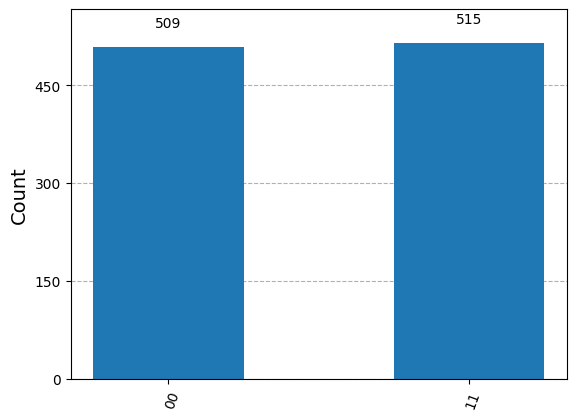

In [23]:
stats = simulate_circuit_histogram(qc, [0,1])
plot_histogram(stats)

---
### Exercice 2 : violation des inégalités de Bell </center>

On s'intéresse à l'expérience quantique suivante : 

<center> <img src="bell_inequalities.PNG" width=300> </center>

i.e, un état de Bell suivi de deux rotations Ry puis la mesure du système. Exceptionnellement, ici les valeurs possibles des mesures seront $\{-1, 1 \}$.

On veut s'intéresser à la corrélation entre $a$ et $b$, définie par 

$$ \mathbb{E}_{\theta_1, \theta_2}(ab) = P(a=b | \theta_1, \theta_2) - P(a\neq b| \theta_1, \theta_2). $$

Plus les résultats des mesures $a, b$ sont corrélés et plus l'espérance sera grande en valeur absolue. À l'inverse, plus les résultats sont décorrélés et plus l'espérance sera proche de $0$. 

Pour deux valeurs possibles de $\theta_1$ et $\theta_2$, on a 4 paires de bases de mesure possibles, donc 4 valeurs possibles de corrélations. On va étudier la quantité 

$$ S = \mathbb{E}_{\theta_1, \theta_2}(ab) - \mathbb{E}_{\theta_1, \theta_2'}(ab) + \mathbb{E}_{\theta_1', \theta_2}(ab) + \mathbb{E}_{\theta_1', \theta_2'}(ab).  $$

Dans l'hypothèse d'une théorie locale à variables cachées, on a 

$$ |S| \leq 2. $$

En effet, en éloignant suffisamment nos deux particules de sorte qu'elles ne puissent plus communiquer durant les mesures, par hypothèse de localité il y aura indépendance entre les deux mesures. Autrement dit, 

$$ P(ab | \theta_1, \theta_2) = P(a | \theta_1) P(b | \theta_2) $$ 

et on aura également 

$$ \mathbb{E}_{\theta_1, \theta_2}(ab) = \mathbb{E}_{\theta_1}(a) \mathbb{E}_{\theta_2}(b) $$ 

ce qui nous permet de réécrire $S$ sous une forme factorisée

$$ S = \mathbb{E}_{\theta_1}(a) \big( \mathbb{E}_{\theta_2}(b) - \mathbb{E}_{\theta'_2}(b) \big) + \mathbb{E}_{\theta'_1}(a) \big( \mathbb{E}_{\theta_2}(b) + \mathbb{E}_{\theta'_2}(b) \big) = A(B-B') + A'(B+B') $$

avec $ -1 \leq A,A',B,B' \leq 1$. Donc 

$$ |S| \leq |B+B'| + |B-B'| $$ 

et on considère trois cas : 

- $0 \leq B \leq B' \leq 1$, dans ce cas $|B+B'| + |B-B'| = 2B' \leq 2$,
- $ -1 \leq B \leq B' \leq 0$, dans ce cas $ |B+B'| + |B-B'| = -2B \leq 2$,
- $ -1 \leq B \leq 0 \leq B' \leq 1$, dans ce cas $ |B+B'| + |B-B'| = 2B' \leq 2$ ou $-2B \leq 2$ selon le signe de $|B+B'|$.

Le cas où $B' \leq B$ se traite de la même manière. 

Dans l'hypothèse d'une théorie locale à variables cachées, on s'autorise également la possibilité d'une variable supplémentaire $\lambda$ partagée entre les particules au moment de leur interaction qui peut conditionner les résultats de la mesure. On réécrit nos probabilités 

$$ P(ab | \theta_1, \theta_2, \lambda) $$

mais cela ne change rien au calcul car la valeur de lambda nous est inconnue au moment de l'expérience et peut varier d'une expérience à l'autre. En répétant un grand nombre de fois l'expérience on moyenne également sur la valeur de lambda, autrement dit lors d'une expérience donnée avec $\theta_1, \theta_2$ fixés on calcule 

$$ \int_\lambda \mathbb{E}_{\theta_1, \theta_2, \lambda}(ab) p(\lambda) d\lambda $$

et 

$$ S = \int_{\lambda} \mathbb{E}_{\theta_1, \theta_2, \lambda}(ab)p(\lambda) d\lambda - \int_{\lambda} \mathbb{E}_{\theta_1, \theta_2', \lambda}(ab)p(\lambda) d\lambda + \int_{\lambda} \mathbb{E}_{\theta_1', \theta_2, \lambda}(ab)p(\lambda) d\lambda + \int_{\lambda} \mathbb{E}_{\theta_1', \theta_2', \lambda}(ab)p(\lambda) d\lambda. $$ 

Pour les mêmes raisons de localité, et par commutation de l'intégrale et de la somme, on peut à nouveau factoriser S et borner la valeur au sein de l'intégrale : 

$$ |S| \leq \int_{\lambda} 2p(\lambda)d\lambda = 2.$$

On va tester cette hypothèse avec notre expérience.

#### **Question 2.1**

<pre> Exprimer l'état mesuré dans la base computationnelle. 
 Quelles sont les probabilités de mesurer 00, 01, 10 et 11 ? </pre>

##### Solution

On applique la matrice 

$$ U = R_y(2\theta_1) \otimes R_y(2\theta_2) $$ 

sur le vecteur $ \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} $. Il suffit de regarder l'image des vecteurs $\ket{00}$ et $\ket{11}$ par $U$ et de sommer les résultats pour avoir l'état final. Par définition du produit de Kronecker on a 

$$ U \ket{00} = \cos(\theta_1) \cos(\theta_2) \ket{00} + \cos(\theta_1) \sin(\theta_2) \ket{01} + \sin(\theta_1)\cos(\theta_2) \ket{10} + \sin(\theta_1)\sin(\theta_2) \ket{11} $$ 
et 
$$ U \ket{11} = \sin(\theta_1) \sin(\theta_2) \ket{00}  -\sin(\theta_1) \cos(\theta_2) \ket{01} + -\cos(\theta_1)\sin(\theta_2) \ket{10} + \cos(\theta_1)\cos(\theta_2) \ket{11}. $$ 

Par somme et en utilisant des identités trigonométriques, on obtient 

$$ \ket{\psi} = \frac{1}{\sqrt{2}} \big( \cos(\theta_1 - \theta_2) \ket{00} + \sin(\theta_1-\theta_2) \ket{01} + \sin(\theta_2-\theta_1) \ket{10} + \cos(\theta_1-\theta_2) \ket{11} \big)$$

dont on en déduit les probabilités de mesure : 

$$ P(00) = P(11) = \frac{1}{2} \cos^2(\theta_1-\theta_2) $$ 
et
$$ P(01) = P(10) = \frac{1}{2} \sin^2(\theta_1-\theta_2). $$

#### **Question 2.2**

<pre> Écrire une routine générant le circuit pour deux valeurs en entrée de theta1, theta2. 
 Vérifiez que les probabilités sont conformes. </pre>

In [24]:
def bell_circ(theta1, theta2):
    nb_qubits = 2

    # Initialisation du circuit
    qc = QuantumCircuit(nb_qubits, nb_qubits)

    # On ajoute les portes que l'on veut 
    qc.h(0)    # Hadamard sur le qubit 0
    qc.cx(0,1) # CNOT sur les qubits 0, 1 (contrôle à 0, cible à 1)
    qc.append(RYGate(2*theta1), [0])
    qc.append(RYGate(2*theta2), [1])
    
    return qc

In [25]:
# Faites des tests
theta1 = np.random.rand()
theta2 = np.random.rand()

circ = bell_circ(theta1, theta2)
circ.draw()

┌───┐     ┌─────────────┐
q_0: ┤ H ├──■──┤ Ry(0.85813) ├
     └───┘┌─┴─┐└┬────────────┤
q_1: ─────┤ X ├─┤ Ry(1.1446) ├
          └───┘ └────────────┘
c: 2/═════════════════════════

In [26]:
stats = simulate_circuit_histogram(circ, [0,1])

print("Probabilités attendues : ")
print("OO et 11 : ", 1/2*np.cos(theta1-theta2)**2)
print("O1 et 10 : ", 1/2*np.sin(theta1-theta2)**2)

print("\nProbabilités obtenues : ")
print("00 : ", stats['00']/1024)
print("01 : ", stats['01']/1024)
print("10 : ", stats['10']/1024)
print("11 : ", stats['11']/1024)

Probabilités attendues : 
OO et 11 :  0.4898154360361014
O1 et 10 :  0.010184563963898614

Probabilités obtenues : 
00 :  0.48046875
01 :  0.009765625
10 :  0.01171875
11 :  0.498046875


#### **Question 2.3** 

<pre> Écrire une routine qui prend en entrée theta1, theta2, et calcule le facteur de corrélation. </pre>

In [27]:
def correlation(theta1, theta2):
    stats = simulate_circuit_histogram(bell_circ(theta1,theta2), [0,1])
    return (stats['00'] + stats['11'] - stats['01'] - stats['10'])/1024

#### **Question 2.4** 

<pre> Calculer S pour theta1 = 0, theta1' = pi/4, theta2 = pi/8 et theta2' = 3pi/8. 
 Que peut-on en conclure ?</pre> 

In [28]:
theta1 = 0
theta12 = np.pi/4
theta2 = np.pi/8
theta22 = 3*np.pi/8

S = correlation(theta1, theta2) - correlation(theta1,theta22) + correlation(theta12, theta2) + correlation(theta12,theta22)
print(S)

2.921875


#### **Question 2.5** 

<pre> Donner une formule simple pour E_(theta1, theta2)(ab).  
 Retrouver la valeur théorique de S pour theta1 = 0, theta1' = pi/4, theta2 = pi/8 et theta2' = 3pi/8. </pre>

##### Solution

$$ E_(\theta_1, \theta_2)(ab) = \cos^2(\theta_1-\theta_2) - \sin^2(\theta_1-\theta_2) = \cos(2(\theta_1-\theta_2)). $$
    
$$ S = \cos(2(\theta_1-\theta_2)) - \cos(2(\theta_1-\theta'_2)) + \cos(2(\theta_1'-\theta_2)) + \cos(2(\theta'_1-\theta'_2)).  $$

    
Pour les valeurs données : 
    
$$ S = \cos(\pi/4) - \cos(3\pi/4) + \cos(\pi/4) + \cos(\pi/4) = 2\sqrt{2} \approx 2.8284. $$

---
### Exercice 3 : la téléportation quantique </center>

Le but de cet exercice est d'échanger un qubit entre deux personnes. Le protocole est le suivant :
<center> <img src="teleportation.PNG" width=300> </center>

Alice possède un qubit dans l'état $\ket{\psi}$ qu'elle aimerait envoyer de manière sécurisée à Bob. Pour cela ils partagent une paire de qubits $\ket{\cdot}_A$ et $\ket{\cdot}_B$ dans l'état de Bell
$$ \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}). $$

Alice possède donc deux qubits, Bob un seul. Alice va effectuer quelques opérations sur ses deux qubits puis les mesurer. Elle va ensuite envoyer classiquement les résultats de sa mesure à Bob qui va effectuer des corrections selon ce qu'Alice va lui envoyer. Plus précisément, et dans cet ordre précis :
- si Alice mesure 1 sur le qubit de l'état de Bell qu'elle partageait avec Bob ($\ket{\cdot}_A$), alors Bob applique une porte X sur son qubit ($\ket{\cdot}_B$),
- si Alice mesure 1 sur le qubit qui contenait initialement son qubit à envoyer ($\ket{\psi}$), alors Bob applique une porte Z sur son qubit ($\ket{\cdot}_B$).

Une fois le protocole réalisé, Bob possède un qubit dans l'état $\ket{\psi}$. D'un point de vue communication, une fois qu'Alice et Bob ont une paire de qubits intriqués, Alice n'a besoin d'envoyer que 2 bits classiques à Bob pour réaliser la téléportation.

#### **Question 3.1**

<pre> Générer un circuit sur 2 qubits qui génère l'état de Bell qu'Alice et Bob vont se partager. </pre>

In [29]:
bell_circ = QuantumCircuit(2)
bell_circ.h(0)
bell_circ.cx(0,1)

bell_circ.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

#### **Question 3.2**
<pre> Générer un circuit sur 2 qubits qui réalise les opérations d'Alice, mesures non incluses. 
 Vous complèterez la fonction ci-dessous qui génère un état aléatoire sur 1 qubit. </pre>

In [30]:
a = 2*np.pi*np.random.rand()
b = 2*np.pi*np.random.rand()
c = 2*np.pi*np.random.rand()

alice_state = np.zeros(2) + 1j*np.zeros(2)
alice_state[0] = 1

Y = np.array([ [0, -1j], [1j, 0]])
Z = np.array([ [1, 0], [0, -1]])
I = np.eye(2)

alice_state = (np.cos(a/2)*I - 1j*np.sin(a/2)*Z) @ alice_state
alice_state = (np.cos(b/2)*I - 1j*np.sin(b/2)*Y) @ alice_state
alice_state = (np.cos(c/2)*I - 1j*np.sin(c/2)*Z) @ alice_state

print("L'état du qubit d'Alice : ", alice_state)

alice_circ = QuantumCircuit(2)
alice_circ.append(RZGate(a), [0])
alice_circ.append(RYGate(b), [0])
alice_circ.append(RZGate(c), [0])

# Complétez alice_circ
alice_circ.cx(0,1)
alice_circ.h(0)

alice_circ.draw()

L'état du qubit d'Alice :  [0.52072818+0.43622114j 0.71681504-0.15725607j]


┌────────────┐┌────────────┐┌────────────┐     ┌───┐
q_0: ┤ Rz(2.6602) ├┤ Ry(4.6352) ├┤ Rz(2.2283) ├──■──┤ H ├
     └────────────┘└────────────┘└────────────┘┌─┴─┐└───┘
q_1: ──────────────────────────────────────────┤ X ├─────
                                               └───┘

#### **Question 3.3**

<pre> Générer un circuit sur 1 qubit avec 2 bits classiques qui réalise les opérations de Bob. </pre>

Pour cela vous utiliserez la syntaxe **circ.gate(j).c_if(i, True)** où i est le numéro du bit classique qui sert de contrôle. Pour rappel gate sera la porte à appliquer (z ou x) et j le qubit sur lequel est appliqué la porte.

In [31]:
bob_circ = QuantumCircuit(1, 2)
bob_circ.x(0).c_if(0, True)
bob_circ.z(0).c_if(1, True)

bob_circ.draw()

C:\Users\abarb\AppData\Local\Temp\ipykernel_1460\1456557382.py:2: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  bob_circ.x(0).c_if(0, True)
C:\Users\abarb\AppData\Local\Temp\ipykernel_1460\1456557382.py:3: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  bob_circ.z(0).c_if(1, True)


┌───┐      ┌───┐   
  q: ───┤ X ├──────┤ Z ├───
        └─╥─┘      └─╥─┘   
     ┌────╨────┐┌────╨────┐
c: 2/╡ c_0=0x1 ╞╡ c_1=0x1 ╞
     └─────────┘└─────────┘

#### **Question 3.4**
<pre> Générer le circuit complet de la téléportation quantique. </pre>

Vous veillerez à réutiliser tous les circuits précédents et vous utiliserez la fonction circ.measure(i,j) où i est le qubit à mesurer et j le bit classique qui va stocker le résultat de la mesure. 

In [32]:
teleportation_circ = QuantumCircuit(3,2)
teleportation_circ = teleportation_circ.compose(bell_circ, [1,2])
teleportation_circ = teleportation_circ.compose(alice_circ, [0,1])
teleportation_circ.measure(0,1)
teleportation_circ.measure(1,0)
teleportation_circ = teleportation_circ.compose(bob_circ, [2], [0,1])
teleportation_circ.measure(0,1)
teleportation_circ.measure(1,0)


teleportation_circ.draw()

┌────────────┐┌────────────┐┌────────────┐     ┌───┐┌─┐           »
q_0: ┤ Rz(2.6602) ├┤ Ry(4.6352) ├┤ Rz(2.2283) ├──■──┤ H ├┤M├───────────»
     └───┬───┬────┘└────────────┘└────────────┘┌─┴─┐└┬─┬┘└╥┘           »
q_1: ────┤ H ├───────────■─────────────────────┤ X ├─┤M├──╫────────────»
         └───┘         ┌─┴─┐                   └───┘ └╥┘  ║    ┌───┐   »
q_2: ──────────────────┤ X ├──────────────────────────╫───╫────┤ X ├───»
                       └───┘                          ║   ║    └─╥─┘   »
                                                      ║   ║ ┌────╨────┐»
c: 2/═════════════════════════════════════════════════╩═══╩═╡ c_0=0x1 ╞»
                                                      0   1 └─────────┘»
«                   ┌─┐
«q_0: ──────────────┤M├
«                ┌─┐└╥┘
«q_1: ───────────┤M├─╫─
«        ┌───┐   └╥┘ ║ 
«q_2: ───┤ Z ├────╫──╫─
«        └─╥─┘    ║  ║ 
«     ┌────╨────┐ ║  ║ 
«c: 2/╡ c_1=0x1 ╞═╩══╩═
«     └─────────┘ 0  1

#### **Question 3.5**
<pre> Faire la simulation du circuit pour récupérer le vecteur d'état en sortie. 
 Comparer avec l'état initial que possédait Alice. </pre>

In [33]:
output_state = simulate_circuit_state(teleportation_circ)
output_state, measurements = simulate_circuit_with_measurements_and_output_state(teleportation_circ, [0,1])
print("État d'Alice (avant téléportation) : ", alice_state)
print("État de Bob (après téléportation) : ", output_state)

État d'Alice (avant téléportation) :  [0.52072818+0.43622114j 0.71681504-0.15725607j]
État de Bob (après téléportation) :  [0.52072818+0.43622114j 0.71681504-0.15725607j]


#### **Question 3.6**
<pre> Les entrées non nulles du vecteur de sortie changent selon la simulation. Pouvez-vous expliquer pourquoi ? </pre>

---

### Expérience quantique 2 : la porte Toffoli et autre circuit logique

<br><br>
La porte Toffoli est une porte logique sur 3 qubits qui réalise l'opération 

$$ [x_1, x_2, x_3] \to [x_1, x_2, x_1 \oplus x_2x_3] $$

où $\oplus$ est l'opérateur XOR. Cette opération correspond aussi à une porte X sur le qubit 3 contrôlée par les qubits 1 et 2. La version unitaire de la Toffoli est 

$$ T = \begin{bmatrix} 1 &&&&&&& \\ &1&&&&&& \\ &&1&&&&& \\ &&&&&&&1 \\ &&&&1&&& \\ &&&&&1&& \\ &&&&&&1& \\ &&&1&&&& \end{bmatrix} $$ 


Le circuit suivant implémente la porte Toffoli : 

<center> <img src="toffoli.PNG" width="700"> </center>



<br><br>
On va créer le circuit, le simuler et vérifier que cela implémente bien l'opérateur voulu. 

In [34]:
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(1,2)
qc.tdg(2)
qc.cx(0,2)
qc.t(2)
qc.cx(1,2)
qc.tdg(2)
qc.cx(0,2)
qc.t(1)
qc.t(2)
qc.cx(0,1)
qc.t(0)
qc.tdg(1)
qc.cx(0,1)
qc.h(2)

qc.draw()

┌───┐      
q_0: ───────────────────■─────────────────────■────■───┤ T ├───■──
                        │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐
q_1: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘
q_2: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────
     └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘

In [35]:
U = simulate_circuit_unitary(qc)
T = np.eye(8)
T[3,3] = T[7,7] = 0
T[7,3] = T[3,7] = 1

print("Erreur d'implémentation : ", np.linalg.norm(U.data-T))

Erreur d'implémentation :  8.598307679924493e-16


On peut également vérifier que notre circuit implémente la Toffoli en rajoutant la Toffoli implémentée dans Qiskit directement dans notre circuit et en vérifiant que le circuit total applique l'identité. Cela nous donne l'occasion de voir comment faire une porte avec un nombre arbitraire de contrôles et d'insérer une porte (ou un sous-circuit) à notre circuit global.

In [36]:
qc2 = qc.copy() # pour éviter que plusieurs exécutions de la cellule fassent s'accumuler des CCX
gate = MCXGate(2)  # Multi Control X Gate, with 2 controls
qc2.append(gate, [0,1,2])
qc2.draw()

┌───┐           
q_0: ───────────────────■─────────────────────■────■───┤ T ├───■────■──
                        │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐  │  
q_1: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├──■──
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘┌─┴─┐
q_2: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────┤ X ├
     └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘      └───┘

In [37]:
U = simulate_circuit_unitary(qc2)
print("Erreur d'implémentation : ", np.linalg.norm(U.data-np.eye(8)))

Erreur d'implémentation :  8.598307679924493e-16


---
###  Exercice 4 : un peu d'arithmétique logique </center>

####  **Question 4.1**


<pre>Simuler le circuit suivant : 

<center> <img src="arithmetic.png" width=700> </center>


Que fait-il ?
Indice : écrivez une fonction qui affiche explicitement l'état de sortie pour chaque 
         bitstring possible en entrée. </pre>

##### Solution

In [38]:
circuit = QuantumCircuit(4)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.t(2)
circuit.cx(2,1)
circuit.cx(2,3)
circuit.cx(0,2)
circuit.cx(2,0)
circuit.tdg(0)
circuit.cx(1,3)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.x(3)
circuit.cx(1,0)
circuit.cx(2,0)
circuit.cx(1,3)
circuit.cx(0,2)
circuit.cx(0,1)

circuit.draw()

┌───┐┌─────┐          ┌───┐┌───┐     »
q_0: ──■────────────────────────■───────┤ X ├┤ Tdg ├──■───────┤ X ├┤ X ├─────»
     ┌─┴─┐          ┌───┐       │       └─┬─┘└─────┘┌─┴─┐     └─┬─┘└─┬─┘     »
q_1: ┤ X ├──■───────┤ X ├───────┼────■────┼─────────┤ X ├──■────■────┼────■──»
     └───┘┌─┴─┐┌───┐└─┬─┘     ┌─┴─┐  │    │         └───┘┌─┴─┐       │    │  »
q_2: ─────┤ X ├┤ T ├──■────■──┤ X ├──┼────■──────────────┤ X ├───────■────┼──»
          └───┘└───┘     ┌─┴─┐└───┘┌─┴─┐┌───┐            └───┘          ┌─┴─┐»
q_3: ────────────────────┤ X ├─────┤ X ├┤ X ├───────────────────────────┤ X ├»
                         └───┘     └───┘└───┘                           └───┘»
«               
«q_0: ──■────■──
«       │  ┌─┴─┐
«q_1: ──┼──┤ X ├
«     ┌─┴─┐└───┘
«q_2: ┤ X ├─────
«     └───┘     
«q_3: ──────────
«

In [39]:
n = circuit.num_qubits

# Pour avoir un bel affichage
a ="{:^"+str(n+3)+"s}|{:^"+str(n+3)+"s}"
print(a.format("Input", " Output"))
print(a.format("", ""))
    
# L'itération sur les bitstrings
for i in range(2**n):
    circ = QuantumCircuit(n, n)
    
    # On récupère la décomposition binaire...
    bin_i = ("{0:0"+str(n)+"b}").format(i)
    
    # ... qui nous donne les X à appliquer
    for j in range(n):
        if bin_i[j] == '1':
            circ.x(j)
        
    # La méthode compose permet de concaténer deux circuits
    circ = circ.compose(circuit, [i for i in range(n)])
    
    # On effectue la mesure
    output = simulate_circuit_measurements(circ, [i for i in range(n)])[0][::-1]

    # On affiche le résultat
    print(a.format(bin_i, output))

 Input | Output
       |       
 0000  | 0001  
 0001  | 0000  
 0010  | 0011  
 0011  | 0010  
 0100  | 0101  
 0101  | 0100  
 0110  | 0111  
 0111  | 0110  
 1000  | 1001  
 1001  | 1000  
 1010  | 1011  
 1011  | 1010  
 1100  | 1101  
 1101  | 1100  
 1110  | 1111  
 1111  | 1110  


---
###  Exercice 5 (bonus pour les plus courageux et rapides !) : synthèse (H,T) (cas particulier du théorème de Solovay-Kitaev) </center>


<u>Rappel du théorème</u> 

<center><i> n'importe quel unitaire sur 1 qubit peut être approximé à une précision arbitraire
    par un circuit de portes H et T. </i></center>
    
<br>    
On introduit l'anneau 
    $$ \mathbb{Z}[\frac{1}{\sqrt{2}},i] = \left\{ \frac{1}{2^n} \left( a + b\sqrt{2} + ci + d\sqrt{2}i \right) \; | \; n \in \mathbb{N}, \; a,b,c,d \in \mathbb{Z} \right\} $$ 

et on définit $ \omega = e^{i\pi/4} = \frac{1}{\sqrt{2}}(1+i)$. On peut réécrire 
    $$ \mathbb{Z}[\frac{1}{\sqrt{2}},i] = \left\{ \frac{1}{2^n} \left( a + b\omega + c\omega^2 + d\omega^3\right) \; | \; n \in \mathbb{N}, \; a,b,c,d \in \mathbb{Z} \right\}. $$ 
    
<u>Version simplifiée du théorème</u> 

<center><i> N'importe quelle unitaire sur 1 qubit dont les entrées sont dans $\mathbb{Z}[\frac{1}{\sqrt{2}},i]$ peut être implémenté exactement avec un circuit de portes H et T. </i></center>    

<u>Esquisse de preuve</u>

1. N'importe quelle unitaire $U$ sur 1 qubit peut s'écrire 
$ U = \begin{bmatrix} z & -y^* e^{i\phi} \\ y & z^* e^{i\phi} \end{bmatrix}$ <br>
    
où $z, y$ sont des complexes quelconques de sorte que $|z|^2 + |y|^2 = 1$, $\phi$ est un réel quelconque. 
    
En supposant maintenant que les entrées de $U$ sont dans $\mathbb{Z}[\frac{1}{\sqrt{2}},i]$, on peut montrer que les seuls éléments de $\mathbb{Z}[\frac{1}{\sqrt{2}},i]$ dont le module vaut 1 sont les $\omega^k$ pour $k$ entier. Autrement dit, si $U$ a ses entrées dans $\mathbb{Z}[\frac{1}{\sqrt{2}},i]$, nécessairement il existe un entier $k$ tel que 
$ U = \begin{bmatrix} z & -y^* \omega^k \\ y & z^* \omega^k \end{bmatrix}$ <br>
    où $z, y \in \mathbb{Z}[\frac{1}{\sqrt{2}},i]$.

<br>
<br>
    
Pour générer $U$, on montre qu'une préparation d'état est essentiellement suffisante. Si l'on a un circuit qui synthétise l'état $\begin{bmatrix} z \\ y \end{bmatrix}$, alors on aura généré un unitaire $V$ de la forme     
    $$ V = \begin{bmatrix} z & -y^* \omega^{k'} \\ y & z^* \omega^{k'} \end{bmatrix}$$
où $k'$ est un entier, possiblement différent de $k$.    

Il suffit alors de remarquer que 
    $$ VT^{k-k'} = \begin{bmatrix} z & -y^* \omega^{k'} \\ y & z^* \omega^{k'} \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & \omega^{k-k'} \end{bmatrix} = \begin{bmatrix} z & -y^* \omega^k \\ y & z^* \omega^k \end{bmatrix} = U. $$

**Question 5.1** 

<pre> Écrire des fonctions qui calculent : 
  - le produit de deux éléments de Z[1/sqrt(2),i],
  - la somme de deux éléments de Z[1/sqrt(2),i],  
  - la norme au carré d'un élément de Z[1/sqrt(2),i],
  - une fonction qui normalise un élément de Z[1/sqrt(2),i] pour avoir le n le plus petit possible.
 
 Pour cela on supposera que de tels éléments sont décrits par 5 entiers n, a, b, c, d selon la deuxième 
 définition de Z[1/sqrt(2),i]. Notamment on remarquera que la norme d'un élément s'écrira toujours 
 1/(2^n)*(a + b\sqrt(2)) et qu'il n'y a besoin que de retourner 3 entiers. </pre>
 
 <br>
Vous pouvez tester vos fonctions sur la cellule de test ci-dessous.

...

In [40]:
def somme(u, v):
    #TODO
    return [0, 0, 0, 0, 0]

...

In [41]:
def product(u, v):
    #TODO
    return [0, 0, 0, 0, 0]

...

In [42]:
def norme(u):
    #TODO
    return [0, 0, 0, 0, 0]

...

In [43]:
def normalize(u):
    #TODO
    return [0, 0, 0, 0, 0]

In [44]:
# Quelques tests

def convert(u):
    omega = np.exp(1j*np.pi/4)
    return 1/2**u[0]*(u[1] + u[2]*omega + u[3]*omega**2 + u[4]*omega**3)

def convert_norme(u):
    return 1/(2**u[0])*(u[1] + np.sqrt(2)*u[2])

u = [np.random.randint(5), np.random.randint(20), np.random.randint(20), np.random.randint(20), np.random.randint(20)]
v = [np.random.randint(5), np.random.randint(20), np.random.randint(20), np.random.randint(20), np.random.randint(20)]

u2 = convert(u)
v2 = convert(v)

w = somme(u,v)
w2 = convert(w)
print("w2-(u2+v2) = ", w2-u2-v2)

w = product(u,v)
w2 = convert(w)
print("w2-(u2*v2) = ", w2-u2*v2)

w = norme(u)
w2 = convert_norme(w)
print("w2 - |u2| = ", w2 - np.abs(u2)**2)

w = normalize(u)
w2 = convert(w)
print("w2 - u2 = ", w2 - u2)

w2-(u2+v2) =  (-8.639087296526013-11.613961030678928j)
w2-(u2*v2) =  (14.735281374238571-47.18807716974935j)
w2 - |u2| =  -30.422465709620866
w2 - u2 =  (-3.1642135623730954-4.517766952966369j)


2. On montre maintenant comment faire la préparation d'état. On définit 
$$ \mathbb{Z}\left[\sqrt{2}\right] = \left\{ a + b\sqrt{2} \; | \; a,b \in \mathbb{Z} \right\}. $$ 
<br>
$$ \mathbb{Z}[1/\sqrt{2}] = \left\{ \frac{1}{2^n}(a + b\sqrt{2}) \; | \; n \in \mathbb{N}, a,b \in \mathbb{Z} \right\}. $$ 

On définit le sde d'un élément $z$ dans $\mathbb{Z}[1/\sqrt{2}]$ par le plus petit entier $k$ tel que $(\sqrt{2})^kz \in \mathbb{Z}[\sqrt{2}]$. 

#### **Question 5.2**

<pre> Écrire une fonction qui calcule le sde d'un élément de Z[1/sqrt(2)]. On rappelle qu'on définit de tels 
 éléments par trois entiers n, a et b. </pre>

##### Solution

...

In [45]:
def sde(u):
    ...

In [46]:
# À nouveau un test pour sde

u = [np.random.randint(10), np.random.randint(200), np.random.randint(200)]
s = sde(u)
u2 = convert_norme(u)

w1 = u2 * np.sqrt(2)**s
for i in range(int(w1)):
    if np.isclose((w1-i)/np.sqrt(2) - int((w1-i)/np.sqrt(2)), 0):
        print("w1 = ", w1, " = u2 * sqrt(2)^s = ", i, " + ", int((w1-i)/np.sqrt(2)), "sqrt(2) = ", i + np.round((w1-i)/np.sqrt(2))*np.sqrt(2))
        print("Erreur = ", (w1-i)/np.sqrt(2) - int((w1-i)/np.sqrt(2)))

w1 = u2 * np.sqrt(2)**(s-1)       
for i in range(int(w1)):
    if np.isclose((w1-i)/np.sqrt(2) - int((w1-i)/np.sqrt(2)), 0):
        print("u2 * sqrt(2)^s = ", i, " + ", int((w1-i)/np.sqrt(2)), "sqrt(2), Erreur = ", (w1-i)/np.sqrt(2) - int((w1-i)/np.sqrt(2)))

TypeError: unsupported operand type(s) for ** or pow(): 'float' and 'NoneType'

Le point essentiel de l'algorithme est de montrer qu'il existe un entier $k \in \{0,1,2,3\}$ de sorte que 
$$ HT^k \begin{bmatrix} z \\ y \end{bmatrix} = \begin{bmatrix} z' \\ y' \end{bmatrix}$$ 
tel que $sde(|z'|^2) = sde(|z|^2) - 1$  si $sde(|z|^2) \geq 4$. On peut ainsi réduire notre état à préparer à un état $\begin{bmatrix} z \\ y \end{bmatrix}$ avec $sde(|z|^2) \leq 3$. La condition de normalisation entre z et y permet de montrer que $sde(|y|^2) = sde(|z|^2) \leq 3$ également. 

On peut ensuite bruteforcer la recherche d'un circuit qui prépare cet état et cela termine l'algorithme. Ci-dessous est fournie une fonction qui fait une telle recherche brute.

In [ ]:
from numpy.linalg import matrix_power

def brute_force_synthesis(U):
    H = 1/np.sqrt(2)*np.array([ [1,1], [1,-1]])
    T = np.diag([1, np.exp(1j*np.pi/4)])
    X = np.array([[0,1], [1,0]])
    I = np.eye(2, dtype=complex)
    
    for i in range(7):
        for j in range(7):
            for k in range(7):
                for l in range(7):
                    for m in range(2):
                        for n in range(2):
                            for o in range(2):
                                for r in range(2):
                                    for s in range(2):
                                        A = matrix_power(X,r)@matrix_power(T,i)@matrix_power(H,m)@matrix_power(T,j)@matrix_power(H,n)@matrix_power(T,k)@matrix_power(H,o)@matrix_power(T,l)@matrix_power(X,s)
                                        if np.isclose(np.linalg.norm(A-U),0):
                                            circ = QuantumCircuit(1)
                                            for p in range(s):
                                                circ.x(0)
                                            for p in range(l):
                                                circ.t(0)
                                            for p in range(o):
                                                circ.h(0)
                                            for p in range(k):
                                                circ.t(0)
                                            for p in range(n):
                                                circ.h(0)
                                            for p in range(j):
                                                circ.t(0)
                                            for p in range(m):
                                                circ.h(0)
                                            for p in range(i):
                                                circ.t(0)
                                            for p in range(r):
                                                circ.x(0)

                                            return circ                                    

Ci-dessous deux fonctions qui génèrent un unitaire aléatoire à entrée dans $\mathbb{Z}[1/\sqrt{2},i]$ en fonction du nombre de H que l'on veut dans le circuit. Si number_of_h <= 3, notre algorithme de recherche doit retrouver un circuit implémentant l'unitaire. 

In [ ]:
def random_unitary(number_of_h):
    H = 1/np.sqrt(2)*np.array([ [1,1], [1,-1]])
    T = np.diag([1, np.exp(1j*np.pi/4)])
    U = np.eye(2, dtype=complex)
    
    for i in range(number_of_h):
        k = np.random.randint(4)
        print(k)
        U = H@matrix_power(T,k)@U
    
    k = np.random.randint(4)
    print(k)
    return matrix_power(T,k)@U

def update(u00, u01, u10, u11, k, with_h):
    h00 = [1, 0, 1, 0, -1]
    h01 = [1, 0, 1, 0, -1]
    h10 = [1, 0, 1, 0, -1]    
    h11 = [1, 0, -1,0, 1]    
    t00 = [0, 1, 0, 0, 0]
    t11 = [0, 0, 1, 0, 0]  
    
    for i in range(k):
        u10 = product(t11, u10)
        u11 = product(t11, u11)
        
    if with_h:
        v00 = somme(product(h00, u00), product(h01, u10))
        v01 = somme(product(h00, u01), product(h01, u11))
        v10 = somme(product(h10, u00), product(h11, u10))
        v11 = somme(product(h10, u01), product(h11, u11))
            
        u00 = normalize(v00)
        u01 = normalize(v01)
        u10 = normalize(v10)
        u11 = normalize(v11)
            
    return u00, u01, u10, u11
    
def check_update(u00, u01, u10, u11, k, with_h):
    v00, v01, v10, v11 = update(u00, u01, u10, u11, k, with_h)
    
    V = np.array([ [convert(v00), convert(v01)], [convert(v10), convert(v11)]])
    U = np.array([ [convert(u00), convert(u01)], [convert(u10), convert(u11)]])
    
    H = 1/np.sqrt(2)*np.array([ [1,1], [1,-1]])
    T = np.diag([1, np.exp(1j*np.pi/4)])
    assert np.isclose(np.linalg.norm(V - matrix_power(H, with_h)@matrix_power(T,k)@U), 0)

def random_unitary_integers(number_of_h):
    u00 = [0,1,0,0,0]
    u01 = [0,0,0,0,0]
    u10 = [0,0,0,0,0]
    u11 = [0,1,0,0,0]
    
    for i in range(number_of_h):
        k = np.random.randint(4)
        u00, u01, u10, u11 = update(u00, u01, u10, u11, k, True)        
    
    k = np.random.randint(4)
    return update(u00, u01, u10, u11, k, False)

In [ ]:
U = random_unitary(3)
matprint(U)

V = random_unitary_integers(5)
print(V)

circ = brute_force_synthesis(U)
U_circ = simulate_circuit_unitary(circ)
matprint(U_circ)
print("Erreur d'implémentation : ", np.linalg.norm(U_circ-U))

Voilà le pseudocode général pour la synthèse (extrait de <i> Fast and efficient exact synthesis of single qubit unitaries generated by Clifford and T gates </i> par Kliuchnikov et al.) : 
<img src="pseudocode_solovay.png" width=500>

#### **Question 5.3** 

<pre> Coder l'algorithme de Kliuchnikov et al. pour la synthèse (H,T) d'unitaires sur 1 qubit. </pre>

#####  Solution

...

In [ ]:
def synthesis_H_T(u00, u01, u10, u11):
   ...

In [ ]:
# On teste que notre fonction se comporte correctement 
u00, u01, u10, u11 = random_unitary_integers(50)
circ = synthesis_H_T(u00, u01, u10, u11)

# On regarde la tête du circuit...
circ.draw()

In [ ]:
# ... et on vérifie que cela implémente bien l'opérateur voulu
U = np.array([ [convert(u00), convert(u01)], [convert(u10), convert(u11)]])                    
U_circ = simulate_circuit_unitary(circ)
print("|U_circ - U| = ", np.linalg.norm(U-U_circ))

#### **Question 5.4 (bonus)** 

<pre> Comparer avec l'implémentation de Qiskit. </pre> 

---
## 3. Implémentation d'algorithmes quantiques </center> 

### Algorithme 1 : Deutsch-Jozsa 

L'algorithme de Deutsch-Jozsa est l'un des premiers algorithmes quantiques inventés. <br>
On a un oracle sous forme de boîte noire, implémentant une fonction booléenne $f : \{0,1\}^n \to \{0,1\}$ et on sait que $f$ est soit constante (i.e, elle retourne $0$ ou $1$ quelle que soit l'entrée) ou équilibrée (pour la moitié des entrées $f$ retourne $0$ et pour l'autre moitié elle retourne $1$). Le problème que l'on veut résoudre est de discriminer si $f$ est constante ou équilibrée et ce avec un nombre minimum d'appels à $f$.

L'algorithme de Deutsch-Jozsa est un algorithme quantique déterministe qui résout ce problème avec un seul appel à la fonction $f$. Pour résoudre ce problème avec un algorithme classique il nous faudrait dans le pire des cas $2^{n-1}+1$ appels à l'oracle pour connaître la valeur de $f$ sur strictement plus que la moitié des entrées. On peut alors savoir si $f$ est constante (si $f$ retourne la même valeur sur toutes les entrées) ou équilibrée (au moins une valeur retournée sera différente des autres). 

Ainsi, l'algorithme de Deutsch-Jozsa offre une amélioration exponentielle de la complexité, passant de $O(2^n)$ appels à la fonction à $1$.

Le circuit quantique pour implémenter l'algorithme est le suivant : 

<img src="dj_algo.png" width=500> 

(extrait de https://en.wikipedia.org/wiki/Deutsch–Jozsa_algorithm)

$U_f$ est une boîte noire implémentant une version réversible de notre oracle $f$, plus précisément on a $U_f(x,y) = (x, y \oplus f(x))$.

Le résultat de la mesure nous donne la nature de $f$:
* si $f$ est constante alors on ne peut que mesurer l'état $\ket{0}^{\otimes n}$,
* si $f$ est équilibré alors on ne peut jamais mesurer l'état $\ket{0}^{\otimes n}$.

Ainsi si on mesure $\ket{0}^{\otimes n}$ alors $f$ est constante, sinon tout autre résultat nous indiquera que $f$ est équilibrée.

On va considérer deux oracles pour cet algorithme.

**1. Hidden weighted bit function sur 4 bits**

La fonction "hidden weighted bit" est une fonction réversible sur $n$ bits. Étant donné une bitstring $x$ en entrée, la fonction va décaler les entrées de $x$ vers la droite $wt(x)$ fois, avec $wt(x)$ retournant le poids de Hamming de $x$.

Exemples : <br>
<center> hwb(1000) = 0100 <center ><br>
<center> hwb(001101) = 101001 <center> <br>

Pour notre première application de l'algorithme de Deutsch-Jozsa, on va utiliser un oracle **basé sur** la fonction hwb4 "hidden weighted bit" sur 4 bits. Voici une implémentation possible de hwb4 avec des CNOT et des Toffoli : 

 <img src="hwb4-11-23.JPG" width=500> 
 
 (extrait de https://reversiblebenchmarks.github.io/hwb4.html, auteurs du circuit : D. Maslov, M. Miller, G. W. Dueck)

#### <b> Question 6.1 </b>
<pre> Écrire un circuit Qiskit implémentant hwb4. </pre>

##### Solution

In [ ]:
hwb4 = QuantumCircuit(4)
hwb4.cx(3,1)
hwb4.cx(1,2)
hwb4.cx(2,0)
hwb4.ccx(1,3,2)
hwb4.cx(0,1)
hwb4.ccx(0,2,3)
hwb4.cx(1,0)
hwb4.ccx(1,3,2)
hwb4.cx(0,3)
hwb4.cx(3,1)
hwb4.cx(2,0)

hwb4.draw()

┌───┐               ┌───┐               ┌───┐
q_0: ──────────┤ X ├───────■────■──┤ X ├───────■───────┤ X ├
     ┌───┐     └─┬─┘     ┌─┴─┐  │  └─┬─┘       │  ┌───┐└─┬─┘
q_1: ┤ X ├──■────┼────■──┤ X ├──┼────■────■────┼──┤ X ├──┼──
     └─┬─┘┌─┴─┐  │  ┌─┴─┐└───┘  │       ┌─┴─┐  │  └─┬─┘  │  
q_2: ──┼──┤ X ├──■──┤ X ├───────■───────┤ X ├──┼────┼────■──
       │  └───┘     └─┬─┘     ┌─┴─┐     └─┬─┘┌─┴─┐  │       
q_3: ──■──────────────■───────┤ X ├───────■──┤ X ├──■───────
                              └───┘          └───┘

#### <b> Question 6.2 </b> 
<pre> Écrire une fonction python qui prend en entrée un circuit réversible et retourne sa table de vérité. 
 Utilisez votre fonction pour vérifier le bon comportement de hwb4. </pre>

##### Solution

In [ ]:
n = hwb4.num_qubits

# Pour avoir un bel affichage
a ="{:^"+str(n+3)+"s}|{:^"+str(n+3)+"s}"
print(a.format("Input", " Output"))
print(a.format("", ""))
    
# L'itération sur les bitstrings
for i in range(2**n):
    circ = QuantumCircuit(n, n)
    
    # On récupère la décomposition binaire...
    bin_i = ("{0:0"+str(n)+"b}").format(i)
    
    # ... qui nous donne les X à appliquer
    for j in range(n):
        if bin_i[j] == '1':
            circ.x(j)
        
    # La méthode compose permet de concaténer deux circuits
    circ = circ.compose(hwb4, [i for i in range(n)])
    
    # On effectue la mesure
    output = simulate_circuit_measurements(circ, [i for i in range(n)])[0][::-1]

    # On affiche le résultat
    print(a.format(bin_i, output))

 Input | Output
       |       
 0000  | 0000  
 0001  | 1000  
 0010  | 0001  
 0011  | 1100  
 0100  | 0010  
 0101  | 0101  
 0110  | 1001  
 0111  | 1110  
 1000  | 0100  
 1001  | 0110  
 1010  | 1010  
 1011  | 0111  
 1100  | 0011  
 1101  | 1011  
 1110  | 1101  
 1111  | 1111  


hwb4 ne peut pas être directement utilisée dans l'algorithme de Deutsch-Jozsa.

On va donc plutôt considérer un oracle qui va retourner la valeur du dernier bit de hwb4(x). On s'attend à ce que l'oracle soit équilibré. 

Autrement dit, avec $z = hwb4(x)$, on veut implémenter l'oracle $f(x) = z[3]$. 

L'opération entière que l'on veut réaliser pour avoir un oracle est 
$$ (x,y) \to (hwb4(x), y) \to (hwb4(x), y \oplus hwb4(x)[3]), \to (x, y \oplus hwb4(x)[3])$$

#### <b> Question 6.3 </b>
<pre> Implémenter l'oracle complet avec un circuit Qiskit. </pre>

##### Solution

In [ ]:
oracle = QuantumCircuit(5)
oracle = oracle.compose(hwb4, [0,1,2,3])
oracle.cx(3,4)
oracle = oracle.compose(hwb4.inverse(), [0,1,2,3])

oracle.draw()

┌───┐               ┌───┐               ┌───┐┌───┐          »
q_0: ──────────┤ X ├───────■────■──┤ X ├───────■───────┤ X ├┤ X ├───────■──»
     ┌───┐     └─┬─┘     ┌─┴─┐  │  └─┬─┘       │  ┌───┐└─┬─┘└─┬─┘┌───┐  │  »
q_1: ┤ X ├──■────┼────■──┤ X ├──┼────■────■────┼──┤ X ├──┼────┼──┤ X ├──┼──»
     └─┬─┘┌─┴─┐  │  ┌─┴─┐└───┘  │       ┌─┴─┐  │  └─┬─┘  │    │  └─┬─┘  │  »
q_2: ──┼──┤ X ├──■──┤ X ├───────■───────┤ X ├──┼────┼────■────■────┼────┼──»
       │  └───┘     └─┬─┘     ┌─┴─┐     └─┬─┘┌─┴─┐  │              │  ┌─┴─┐»
q_3: ──■──────────────■───────┤ X ├───────■──┤ X ├──■────■─────────■──┤ X ├»
                              └───┘          └───┘     ┌─┴─┐          └───┘»
q_4: ──────────────────────────────────────────────────┤ X ├───────────────»
                                                       └───┘               »
«          ┌───┐               ┌───┐          
«q_0: ─────┤ X ├──■────■───────┤ X ├──────────
«          └─┬─┘  │  ┌─┴─┐     └─┬─┘     ┌───┐
«q_1: ──■────■────┼──┤ X ├──■────┼────■──┤ X ├
«     ┌─┴─┐       │  └───┘┌─┴─┐  │  ┌─┴─┐└─┬─┘
«q_2: ┤ X ├───────■───────┤ X ├──■──┤ X ├──┼──
«     └─┬─┘     ┌─┴─┐     └─┬─┘     └───┘  │  
«q_3: ──■───────┤ X ├───────■──────────────■──
«               └───┘                         
«q_4: ────────────────────────────────────────
«

In [ ]:
n = oracle.num_qubits

# Pour avoir un bel affichage
a ="{:^"+str(n+3)+"s}|{:^"+str(n+3)+"s}"
print(a.format("Input", " Output"))
print(a.format("", ""))
    
# L'itération sur les bitstrings
for i in range(2**n):
    circ = QuantumCircuit(n, n)
    
    # On récupère la décomposition binaire...
    bin_i = ("{0:0"+str(n)+"b}").format(i)
    
    # ... qui nous donne les X à appliquer
    for j in range(n):
        if bin_i[j] == '1':
            circ.x(j)
        
    # La méthode compose permet de concaténer deux circuits
    circ = circ.compose(oracle, [i for i in range(n)])
    
    # On effectue la mesure
    output = simulate_circuit_measurements(circ, [i for i in range(n)])[0][::-1]

    # On affiche le résultat
    print(a.format(bin_i, output))

 Input  | Output 
        |        
 00000  | 00000  
 00001  | 00001  
 00010  | 00010  
 00011  | 00011  
 00100  | 00101  
 00101  | 00100  
 00110  | 00110  
 00111  | 00111  
 01000  | 01000  
 01001  | 01001  
 01010  | 01011  
 01011  | 01010  
 01100  | 01101  
 01101  | 01100  
 01110  | 01110  
 01111  | 01111  
 10000  | 10000  
 10001  | 10001  
 10010  | 10010  
 10011  | 10011  
 10100  | 10100  
 10101  | 10101  
 10110  | 10111  
 10111  | 10110  
 11000  | 11001  
 11001  | 11000  
 11010  | 11011  
 11011  | 11010  
 11100  | 11101  
 11101  | 11100  
 11110  | 11111  
 11111  | 11110  


#### **Question 6.4**

<pre> Implémenter l'algorithme de Deutsch-Jozsa. Le tester sur hwb4 et sur l'oracle de la question 4.1. </pre>

##### Solution

In [ ]:
deutsch_circ = QuantumCircuit(5, 4)
deutsch_circ.x(4)
deutsch_circ.h(range(5))
deutsch_circ = deutsch_circ.compose(oracle)
deutsch_circ.h(range(4))

deutsch_circ.draw()

┌───┐          ┌───┐               ┌───┐               ┌───┐┌───┐     »
q_0: ┤ H ├──────────┤ X ├───────■────■──┤ X ├───────■───────┤ X ├┤ X ├─────»
     ├───┤┌───┐     └─┬─┘     ┌─┴─┐  │  └─┬─┘       │  ┌───┐└─┬─┘└─┬─┘┌───┐»
q_1: ┤ H ├┤ X ├──■────┼────■──┤ X ├──┼────■────■────┼──┤ X ├──┼────┼──┤ X ├»
     ├───┤└─┬─┘┌─┴─┐  │  ┌─┴─┐└───┘  │       ┌─┴─┐  │  └─┬─┘  │    │  └─┬─┘»
q_2: ┤ H ├──┼──┤ X ├──■──┤ X ├───────■───────┤ X ├──┼────┼────■────■────┼──»
     ├───┤  │  └───┘     └─┬─┘     ┌─┴─┐     └─┬─┘┌─┴─┐  │              │  »
q_3: ┤ H ├──■──────────────■───────┤ X ├───────■──┤ X ├──■────■─────────■──»
     ├───┤┌───┐                    └───┘          └───┘     ┌─┴─┐          »
q_4: ┤ X ├┤ H ├─────────────────────────────────────────────┤ X ├──────────»
     └───┘└───┘                                             └───┘          »
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«               ┌───┐               ┌───┐┌───┐          
«q_0: ──■───────┤ X ├──■────■───────┤ X ├┤ H ├──────────
«       │       └─┬─┘  │  ┌─┴─┐     └─┬─┘└───┘┌───┐┌───┐
«q_1: ──┼────■────■────┼──┤ X ├──■────┼────■──┤ X ├┤ H ├
«       │  ┌─┴─┐       │  └───┘┌─┴─┐  │  ┌─┴─┐└─┬─┘├───┤
«q_2: ──┼──┤ X ├───────■───────┤ X ├──■──┤ X ├──┼──┤ H ├
«     ┌─┴─┐└─┬─┘     ┌─┴─┐     └─┬─┘     └───┘  │  ├───┤
«q_3: ┤ X ├──■───────┤ X ├───────■──────────────■──┤ H ├
«     └───┘          └───┘                         └───┘
«q_4: ──────────────────────────────────────────────────
«                                                       
«c: 4/══════════════════════════════════════════════════
«

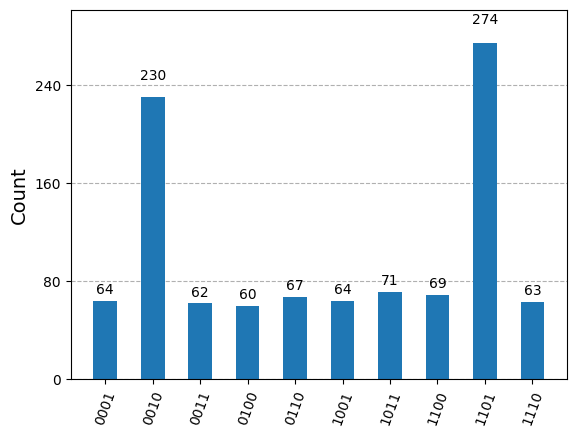

In [ ]:
results = simulate_circuit_histogram(deutsch_circ, [0,1,2,3])
plot_histogram(results)

In [ ]:
deutsch_circ2 = QuantumCircuit(4, 3)
deutsch_circ2.x(3)
deutsch_circ2.h(range(4))
deutsch_circ2 = deutsch_circ2.compose(circuit)
deutsch_circ2.h(range(3))

deutsch_circ2.draw()

┌───┐                                   ┌───┐┌─────┐          ┌───┐┌───┐»
q_0: ┤ H ├──■────────────────────────■───────┤ X ├┤ Tdg ├──■───────┤ X ├┤ X ├»
     ├───┤┌─┴─┐          ┌───┐       │       └─┬─┘└─────┘┌─┴─┐     └─┬─┘└─┬─┘»
q_1: ┤ H ├┤ X ├──■───────┤ X ├───────┼────■────┼─────────┤ X ├──■────■────┼──»
     ├───┤└───┘┌─┴─┐┌───┐└─┬─┘     ┌─┴─┐  │    │         └───┘┌─┴─┐       │  »
q_2: ┤ H ├─────┤ X ├┤ T ├──■────■──┤ X ├──┼────■──────────────┤ X ├───────■──»
     ├───┤┌───┐└───┘└───┘     ┌─┴─┐└───┘┌─┴─┐┌───┐            └───┘          »
q_3: ┤ X ├┤ H ├───────────────┤ X ├─────┤ X ├┤ X ├───────────────────────────»
     └───┘└───┘               └───┘     └───┘└───┘                           »
c: 3/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                    ┌───┐
«q_0: ───────■────■──┤ H ├
«            │  ┌─┴─┐├───┤
«q_1: ──■────┼──┤ X ├┤ H ├
«       │  ┌─┴─┐├───┤└───┘
«q_2: ──┼──┤ X ├┤ H ├─────
«     ┌─┴─┐└───┘└───┘     
«q_3: ┤ X ├───────────────
«     └───┘               
«c: 3/════════════════════
«

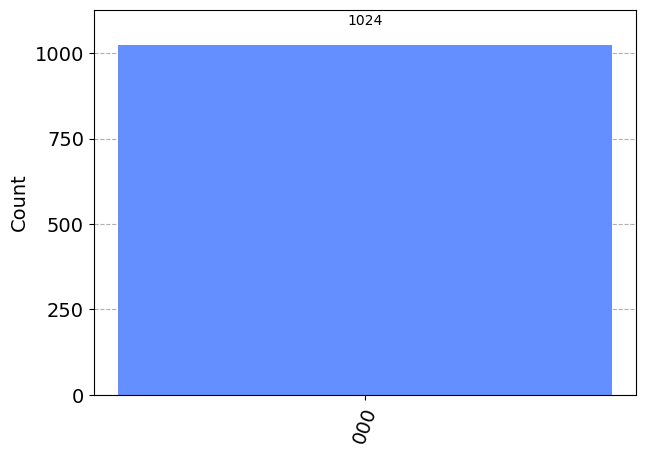

In [ ]:
results = simulate_circuit_histogram(deutsch_circ2, [0,1,2])
plot_histogram(results)

---

### Algorithme 2 : l'algorithme de Grover


<br><br>
L'algorithme de Grover permet de trouver des éléments dans une base de données non structurée en temps $O(\sqrt{N})$ où $N$ est la taille de la base de données. L'élément à trouver doit répondre à un critère calculable, par exemple dans une liste de mots trouver un mot avec deux fois la lettre "r". L'algorithme de Grover marche quel que soit le nombre d'éléments qui répondent au critère dans la base de données. 
<br> <br>
L'algorithme consiste en les blocs suivants: <br>
* un oracle $U_{\omega}$ qui applique une phase de -1 à toute bitstring satisfaisant le critère, 
* un opérateur de diffusion défini par $H^{\otimes n} \left(2 \ket{0}^{\otimes n}\bra{0}^{\otimes n} - I_n \right) H^{\otimes n}$

<br> 
<br> 
Et le circuit final est 

<img src="grover_algo.png" width=700> 

(extrait de https://fr.wikipedia.org/wiki/Algorithme_de_Grover)

#### **Question 7.1** 

<pre> coder une fonction qui prend en entrée le nombre de qubits, le nombre de qubits ancillaires, le circuit de l'oracle, le nombre d'itérations et retourne le circuit total de Grover. </pre>

##### Solution

In [ ]:
def grover(nb_qubits, nb_ancillas, oracle, niter):
    
    grover_circ = QuantumCircuit(nb_qubits + nb_ancillas, nb_qubits)
    grover_circ.h(range(nb_qubits))
    
    for i in range(niter):
        grover_circ = grover_circ.compose(oracle)
        grover_circ.h(range(nb_qubits)) 
        
        # CCC...CZ avec contrôles à 0
        grover_circ.x(range(nb_qubits))
        
        # CCC...CZ
        grover_circ.h(nb_qubits-1)
        grover_circ.append(MCXGate(nb_qubits-1), [i for i in range(nb_qubits)])
        grover_circ.h(nb_qubits-1)  
        
        # CCC...CZ avec contrôles à 0
        grover_circ.x(range(nb_qubits))
        
        grover_circ.h(range(nb_qubits))
    
    return grover_circ

#### **Question 7.2** 

<pre> Tester l'algorithme sur une CCCCZ pour retrouver l'état |11111> et vérifier 
 que votre implémentation fonctionne avec la cellule test ci-dessous. </pre>

In [ ]:
qubits_database = 5
qubits_ancillaires = 0

ccccz = QuantumCircuit(qubits_database+qubits_ancillaires)
ccccz.h(4)
ccccz.append(MCXGate(4), [0,1,2,3,4])
ccccz.h(4)

niter = 11
grover_circuit = grover(5, 0, ccccz, niter)

grover_circuit.draw()

┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤»
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤»
q_2: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤»
q_3: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤»
q_4: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 5/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐               ┌───┐┌───┐               »
«q_0: ┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──»
«     ├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  »
«q_1: ┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──»
«     ├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  »
«q_2: ┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──»
«     ├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  »
«q_3: ┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──»
«     ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐»
«q_4: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐┌───┐          »
«q_0: ┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────────»
«     ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤          »
«q_1: ┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────────»
«     ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤          »
«q_2: ┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────────»
«     ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤          »
«q_3: ┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────────»
«     ├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐»
«q_4: ┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐┌───┐     »
«q_0: ──■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├─────»
«       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤     »
«q_1: ──■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├─────»
«       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤     »
«q_2: ──■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├─────»
«       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤├───┤     »
«q_3: ──■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├─────»
«     ┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐»
«q_4: ┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                       

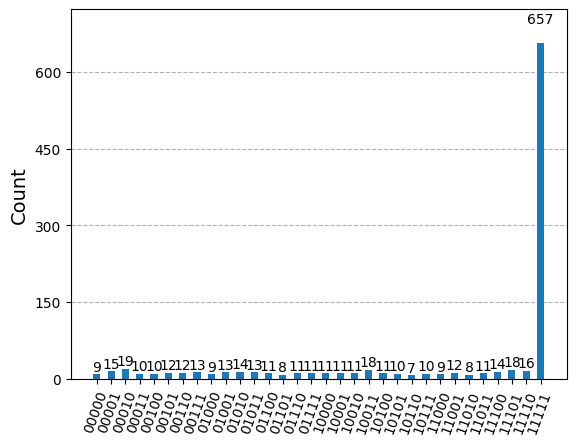

In [ ]:
results = simulate_circuit_histogram(grover_circuit, [0,1,2,3,4])
plot_histogram(results)

On va maintenant appliquer Grover sur le problème suivant : le permanent d'une matrice est une valeur numérique donnée par une formule proche du déterminant (sans l'alternance des signes). On veut savoir, parmi les matrices binaires de taille 2, resp. 3, s'il en existe qui ont un permanent égal à 2, resp. 4, 5 ou 6. 

Ci-dessous sont des implémentations réversibles du calcul du permanent pour des matrices 2x2 : 

<img src="perm2x2.svg" width="150">

(extrait de https://reversiblebenchmarks.github.io/permanent2x2.html, auteur du circuit : D. V. Zakablukov)
     
     
et 3x3 : 

<img src="perm3x3.svg" width="800">

(extrait de https://reversiblebenchmarks.github.io/permanent3x3.html, auteur du circuit : D. V. Zakablukov)

Les matrices 2x2 sont encodées sur 4 qubits, les 3x3 sur 9 qubits. Les 2, resp. 3 premiers qubits sont utilisés pour stocker la valeur du permanent en binaire. Ainsi le nombre total de qubits est de 6, resp. 12. Pour expliciter l'ordre des bits, par exemple dans le cas 2x2 le permanent en binaire sera donné par a2a1.

#### **Question 7.3**
<pre> Générer les circuits des oracles correspondants. 
 Note : l'oracle doit "juste" inverser les phases des solutions, autrement dit il faut que les qubits 
 ancillaires soient intouchés à la fin de l'application de l'oracle. </pre>

#####  Solution

In [ ]:
def perm_2_2_oracle():
    oracle = QuantumCircuit(6)
    
    # Calcul du permanent
    oracle.append(MCXGate(4), [0,1,2,3,5])
    oracle.append(MCXGate(2), [0,3,4])
    oracle.append(MCXGate(2), [1,2,4])
    
    # Création de la phase
    oracle.x(4)
    oracle.cz(4,5)
    oracle.x(4)
    
    # "Décalcul" du permanent 
    oracle.append(MCXGate(2), [1,2,4])
    oracle.append(MCXGate(2), [0,3,4])
    oracle.append(MCXGate(4), [0,1,2,3,5])
    
    return oracle

def perm_3_3_oracle():
    oracle = QuantumCircuit(12)
    
    oracle.append(MCXGate(8), [1,2,3,4,5,6,7,8,11])
    oracle.append(MCXGate(8), [0,2,3,4,5,6,7,8,11])
    oracle.append(MCXGate(8), [0,1,3,4,5,6,7,8,11])
    oracle.append(MCXGate(8), [0,1,2,4,5,6,7,8,11])
    oracle.append(MCXGate(8), [0,1,2,3,5,6,7,8,11])
    oracle.append(MCXGate(8), [0,1,2,3,4,6,7,8,11])
    oracle.append(MCXGate(8), [0,1,2,3,4,5,7,8,11])
    
    oracle.append(MCXGate(5), [0,4,5,7,8,10])
    oracle.append(MCXGate(6), [0,1,3,5,7,8,10])
    oracle.append(MCXGate(6), [0,2,3,4,7,8,10])
    oracle.append(MCXGate(5), [1,2,3,7,8,10])
    
    oracle.append(MCXGate(8), [0,1,2,3,4,5,6,8,11])
    
    oracle.append(MCXGate(6), [0,1,4,5,6,8,10])
    oracle.append(MCXGate(5), [1,3,5,6,8,10])
    oracle.append(MCXGate(6), [1,2,3,4,6,8,10])
    oracle.append(MCXGate(5), [0,2,4,6,8,10])
    oracle.append(MCXGate(5), [0,1,3,4,8,10])
    
    oracle.append(MCXGate(3), [0,4,8,9])
    oracle.append(MCXGate(3), [1,3,8,9])
    
    oracle.append(MCXGate(8), [0,1,2,3,4,5,6,7,11])
    
    oracle.append(MCXGate(6), [0,2,4,5,6,7,10])
    oracle.append(MCXGate(6), [1,2,3,5,6,7,10])
    oracle.append(MCXGate(5), [0,1,5,6,7,10])
    oracle.append(MCXGate(5), [2,3,4,6,7,10])
    oracle.append(MCXGate(5), [0,2,3,5,7,10])
    
    oracle.append(MCXGate(3), [0,5,7,9])
    oracle.append(MCXGate(3), [2,3,7,9])
    
    oracle.append(MCXGate(5), [1,2,4,5,6,10])
    
    oracle.append(MCXGate(3), [1,5,6,9])
    oracle.append(MCXGate(3), [2,4,6,9])
    
    full_oracle = QuantumCircuit(12)
    
    full_oracle = full_oracle.compose(oracle, [i for i in range(12)])
    
    # Exécutez ça pour chercher un permanent égal à 6
    #full_oracle.x(9)
    #full_oracle.ccz(9,10,11)
    #full_oracle.x(9)
    
    # Exécutez ça pour chercher un permanent égal à 5
    full_oracle.x(10)    
    full_oracle.ccz(9,10,11)
    full_oracle.x(10) 
    
    
    # Exécutez ça pour chercher un permanent égal à 4
    #full_oracle.x(9)
    #full_oracle.x(10)    
    #full_oracle.ccz(9,10,11)
    #full_oracle.x(9)
    #full_oracle.x(10) 
    
    
    full_oracle = full_oracle.compose(oracle.reverse_ops(), [i for i in range(12)])
    
    return full_oracle

#### **Question 7.4**

<pre> Utiliser l'algorithme de Grover pour répondre aux problèmes posés. </pre>

##### Solution

                                                ┌───┐┌───┐          ┌───┐┌───┐»
q_0: ──■────■───────────────────────────■────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├»
       │    │                           │    │  ├───┤├───┤       │  ├───┤├───┤»
q_1: ──■────┼────■─────────────────■────┼────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├»
       │    │    │                 │    │    │  ├───┤├───┤       │  ├───┤├───┤»
q_2: ──■────┼────■─────────────────■────┼────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├»
       │    │    │                 │    │    │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤»
q_3: ──■────■────┼─────────────────┼────■────■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»
       │  ┌─┴─┐┌─┴─┐┌───┐   ┌───┐┌─┴─┐┌─┴─┐  │  └───┘└───┘└───┘└───┘└───┘└───┘»
q_4: ──┼──┤ X ├┤ X ├┤ X ├─■─┤ X ├┤ X ├┤ X ├──┼────────────────────────────────»
     ┌─┴─┐└───┘└───┘└───┘ │ └───┘└───┘└───┘┌─┴─┐                              »
q_5: ┤ X ├────────────────■────────────────┤ X ├──────────────────────────────»
     └───┘                              

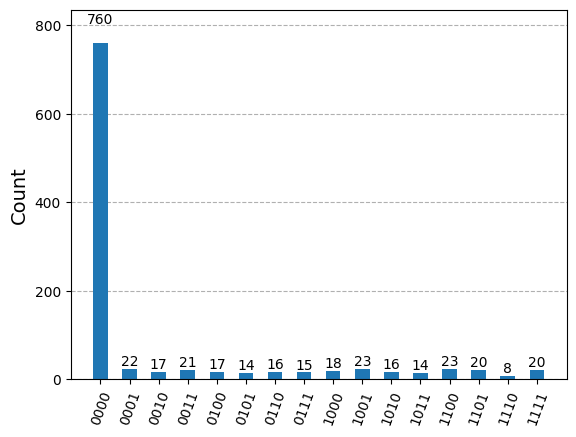

In [ ]:
# On simule notre circuit pour le permanent 2x2

niter = 1
grover_circ = grover(4, 2, perm_2_2_oracle(), niter)
print(grover_circ.draw())

output_state = simulate_circuit_state(grover_circ)
#print(output_state)

measurement = simulate_circuit_measurements(grover_circ, [0,1,2,3])
print(measurement)

counts = simulate_circuit_histogram(grover_circ, [0,1,2,3])
plot_histogram(counts)

La seule matrice avec un permanent de 2 est $\begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}$.

['010011011']


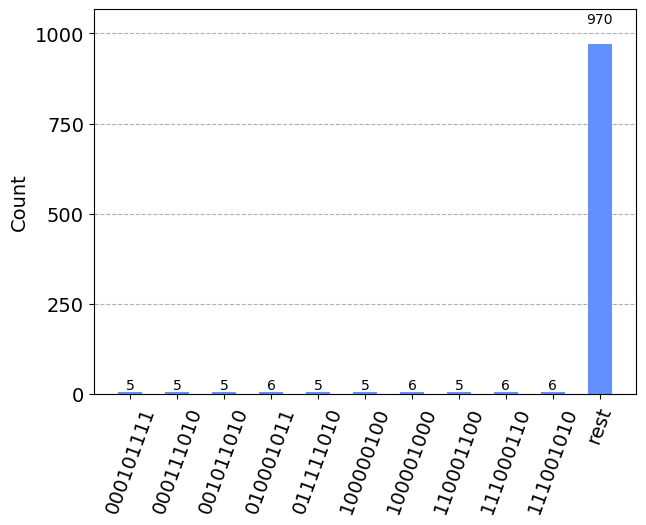

In [ ]:
# On simule notre circuit pour le permanent 3x3

niter = 8
grover_circuit = grover(9, 3, perm_3_3_oracle(), niter)
decomposed_grover = grover_circuit.decompose()

measurement = simulate_circuit_measurements(decomposed_grover, [i for i in range(9)])
print(measurement)

counts = simulate_circuit_histogram(decomposed_grover, [i for i in range(9)])
# On ne garde que les résultats les plus fréquents pour ne pas surcharger le plot
plot_histogram(counts, number_to_keep=10)

* Seule la matrice $M = \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$ a un permanent égal à 6. 

* Aucune matrice n'a un permanent égal à 5. 

* 9 matrices ont un permanent égal à 4, ce sont toutes celles partant de $M$ et à laquelle une entrée a été mise à 0.

---

## Algorithme 3 : Quantum Phase Estimation (QPE)

L'algorithm d'estimation de phase quantique permet d'estimer la valeur propre (ou phase) d'un opérateur unitaire associée à un vecteur propre donné. Pour un opérateur unitaire $U$, on rappelle que les valeurs propres sont toutes de module égal à 1. Si $\ket{\psi}$ est vecteur propre d'un opérateur unitaire $U$ alors on peut écrire

$$
U \ket{\psi} = e^{2 i \pi \theta} \ket{\psi}
$$

et cet algorithme permet de retrouver la valeur $\theta$ correspondant au vecteur propre $\ket{\psi}$, avec une précision de $n$ bits. Le circuit correspondant àl'algorithme de la QPE est le suivant :

<img src="qpe.png" width="600">

Le circuit se décompose en plusieures étapes clés.
1) Superposition : Grace à un mur de porte Hadamard, on crée une superposition de tous les entiers possibles sur notre registre ancillaire. Le système quantique est alors dans l'état
$$
\sum_{k=0}^{2^n - 1}\ket{k}\ket{\psi}.
$$
2) Succession d'opérations unitaires contrôlées : cette étape cruciale permet d'encoder dans la phase de l'état ancillaire la valeur propre associée au vecteur propre $\ket{\psi}$. Comme $\ket{\psi}$ est vecteur propre de $U$ de valeur propre associée $e^{2 i \pi \theta}$, on a $U^{2j}\ket{\psi} = e^{2^j \times 2i \pi \theta}$. Ainsi après avoir appliqué cette succession d'opérations unitaires contrôlées par l'état $\ket{\psi}$ notre système quantique se trouve dans l'état
$$
\frac{1}{\sqrt{2}^n} \sum_{k=0}^{2^n-1} e^{2i \pi \theta k}\ket{k} \ket{\psi}.
$$
3) Transformée de Fourier inverse : Le résultat précédent peut être interprétée comme une transformée de Fourier et appliquant une transformée de Fourier inverse on trouve
$$
\frac{1}{2^n}\sum_{x=0}^{2^n-1}\sum_{k=0}^{2^n-1} e^{-\frac{2i\pi k}{2^n}(x - 2^n\theta)}\ket{x}\ket{\psi}.
$$
Comme nous le verrons dans la suite il existe un algorithme quantique pour la Transformée de Fourier et nous allons l'implémenter.
4) Mesure : L'expression ci-dessus présente un pic pour $x = 2^n \theta$. Si $2^n \theta$ est un entier alors on est sûr d'obtenir après mesure l'état $\ket{2^n \theta} \ket{\psi}$. Dans le cas où ce nest pas un entier, il a été montré qu'on a tout de même un pic pour $x = 2^n \theta$ et que cette fois on a une probabilité supérieure à $4/\pi^2 \approx 40%$ d'obtenir le bon résultat après la mesure.

Nous allons détailler chaque étape de l'algorithme au travers de cet exercice. Ici nous allons nous intéresser à la porte T pour faire simple. La porte T rajoute une phase de $e^{i\pi/4}$ à l'état $\ket{1}$ puisque
$$
T = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{pmatrix}.
$$
Comme la QPE nous donne $\theta$ dans le cas où $T\ket{1} = e^{2i\pi \theta} \ket{1}$ on s'attend à obtenir en sortie de l'algorithme $\theta = 1/8$.

#### Séquence d'opérations unitaires contrôlées

Tout d'abord, concentrons nous sur la séquence d'opérations unitaires contrôlées. Nous allons implémenter le circuit suivant pour la porte T

RAJOUTER IMAGE

On rappelle qu'appliquer $T^k$ dans un circuit quantique est équivalent à appliquer l'opérateur $T$ successivement, $k$ fois.

##### **Question** 
<pre> Implémenter le circuit correspondant à cette séquence d'opérations contrôlées, pour un nombre de qubits ancillaires donné en paramètre. </pre>

In [ ]:
def CU_sequence(nb_anc):
    circuit = QuantumCircuit(nb_anc + 1)
    for i in range(nb_anc):
        for j in range(2**i):
            circuit = circuit.compose(TGate().control(1), [i, nb_anc])
    return circuit

circuit = CU_sequence(4)
circuit.draw()


»
q_0: ──■───────────────────────────────────────────────────────────────────»
       │                                                                   »
q_1: ──┼────■────■─────────────────────────────────────────────────────────»
       │    │    │                                                         »
q_2: ──┼────┼────┼────■────■────■────■─────────────────────────────────────»
       │    │    │    │    │    │    │                                     »
q_3: ──┼────┼────┼────┼────┼────┼────┼────■────■────■────■────■────■────■──»
     ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
q_4: ┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├┤ T ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«          
«q_0: ─────
«          
«q_1: ─────
«          
«q_2: ─────
«          
«q_3: ──■──
«     ┌─┴─┐
«q_4: ┤ T ├
«     └───┘

#### Quantum Fourier Transform (QFT)

La Transformée de Fourier Quantique est l'analogie quantique de la Transformée de Fourier Discrète. Elle agit sur un état quantique $\ket{x} = \sum_{i=0}^{N-1} x_i \ket{i}$ et renvoie l'état $\sum_{i=0}^{N-1} y_i \ket{i}$ tel que

$$
y_k = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} x_n \omega_N^{nk}
$$
où $\omega_N = exp(2 \pi i / N)$.

Le circuit suivant permet de réaliser une QFT sur 4 qubits, et est triviallement généralisable à n'importe quel nombre de qubits

<img src="qft.png" width=500>

##### **Question 8.1**
<pre> Implementer une routine quantique qui prend en entrée le nombre de qubits et qui renvoie le circuit quantique de la QFT (La porte P controlée peut être construite avec circuit.cp(theta, ))</pre> 

**/!\ le circuit quantique de la QFT inverse l'ordre des qubits en sortie. Il faudra donc utiliser des portes SWAP (qu'on peut appeler avec circuit.swap(qubit1, qubit2)) pour inverser l'ordre de tous les qubits à la fin du circuit**

In [ ]:
def qft(nb_qubits):
    circuit = QuantumCircuit(nb_qubits)
    
    for i in range(nb_qubits):
        circuit.h(nb_qubits - i - 1)
        for c in range(1, nb_qubits-i):
            theta = np.pi / 2**(c)
            circuit.cp(theta, nb_qubits - i - 1, nb_qubits - i - c - 1)
    for i in range(nb_qubits // 2):
        circuit.swap(i, nb_qubits-i-1)
    return circuit

qft(4).draw()

┌───┐»
q_0: ─────────────────────────────■─────────────────■─────────────■───────┤ H ├»
                                  │                 │       ┌───┐ │P(π/2) └───┘»
q_1: ───────────────■─────────────┼────────■────────┼───────┤ H ├─■─────────X──»
                    │       ┌───┐ │        │P(π/2)  │P(π/4) └───┘           │  »
q_2: ──────■────────┼───────┤ H ├─┼────────■────────■───────────────────────X──»
     ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)                                      »
q_3: ┤ H ├─■────────■─────────────■────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

Pour tester notre implémentation de la QFT nous allons essayer de résoudre un problème de recherche de fréquences (comme on pourrait le faire avec une Tranformée de Fourier classique). Pour cela on va étudier le signal encodé dans un état quantique à 5 qubits. Ci dessous, on visualise ce signal composé de deux cosinus, échantilloné sur $5^2 = 32$ valeurs.

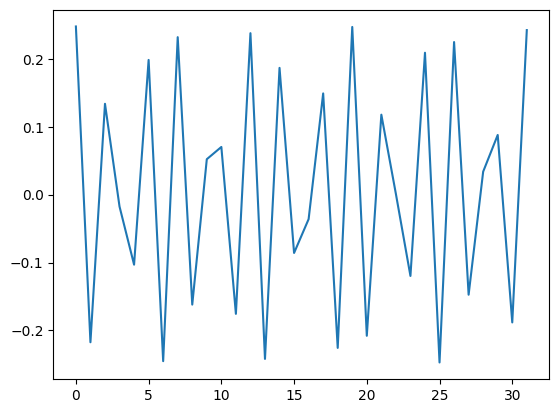

In [ ]:
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt 

n = 5
X = np.arange(0, 2**n)
signal = np.array(np.cos(0.5*X) * np.cos(np.pi * X))  # Signal dont on étudie les fréquences
signal /= np.linalg.norm(signal)  # Normalisation du signal pour l'encodage quantique
qsignal = Statevector(signal)

plt.plot(X, signal)
plt.show()


Le signal était composé de 2 sinusoïdes, dans le domaine de Fourier on observe 2 pics.

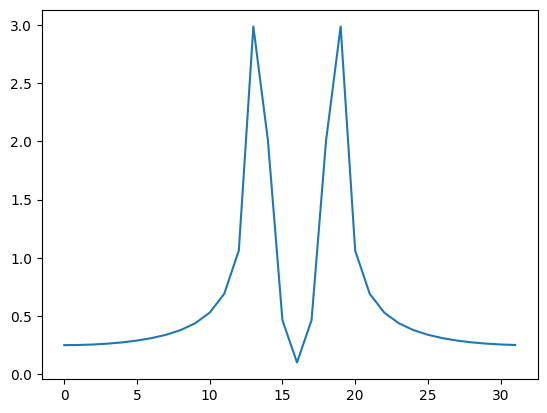

In [ ]:
fft_signal = np.fft.fft(signal)
plt.plot(X, np.abs(fft_signal))
plt.show()

Maintenant, testons notre QFT sur ce même signal. On obtiens un histogramme très proche de la courbe dans le domaine de Fourier ci-dessus.

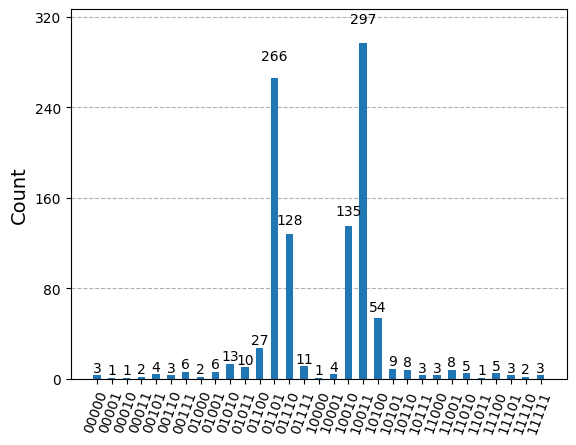

In [ ]:
circuit = QuantumCircuit(n, n)
circuit.initialize(qsignal, range(n))  # Encode the signal in the quantum state
circuit = circuit.compose(qft(5), range(5))  # Add the QFT in the quantum circuit


stats = simulate_circuit_histogram(circuit, range(n)[::-1])
plot_histogram(stats)

#### Implémentation complète de la QPE

Maintenant que nous avons tous les blocs nécessaires à notre implémentation de la QPE, nous pouvons la tester. Pour rappel, si on souhaite implémenter la QPE il faut
1) Initialiser l'état $\ket{psi} à la valeur du vecteur propre donc $\ket{1}$
2) Appliquer un mur de portes Hadamard sur les qubits ancillaires
3) Appliquer la séquence des unitaires contrôlées
4) Utiliser l'inverse de la QFT sur les qubits ancillaires
5) Mesure le registre ancillaire pour obtenir la valeur propre

##### **Question**
<pre> Implémenter l'algorithme de la QPE et observer l'histogramme en sortie du circuit pour un nombre d'ancilla égal à 3. </pre>

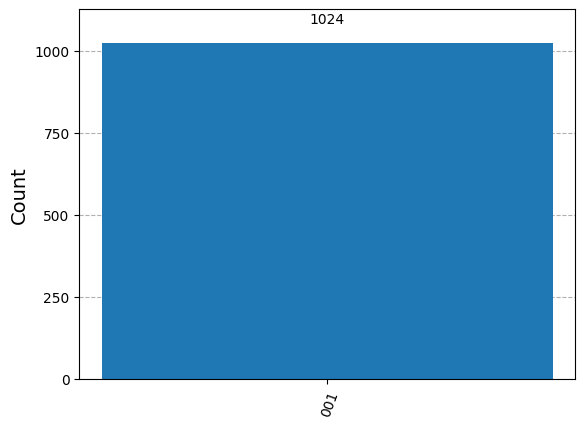

In [ ]:
nb_anc = 3

def QPE(nb_anc):
    circuit = QuantumCircuit(nb_anc + 1, nb_anc)
    circuit.x(nb_anc)  # Initialisation du vecteur propre à 1

    # Mur de portes Hadamard sur les ancillas
    for i in range(nb_anc):
        circuit.h(i)
    # CU sequence
    circuit = circuit.compose(CU_sequence(nb_anc), range(nb_anc + 1))
    # QFT inverse
    circuit = circuit.compose(qft(nb_anc).inverse(), range(nb_anc))
    return circuit

stats = simulate_circuit_histogram(QPE(nb_anc), range(nb_anc)[::-1])
plot_histogram(stats)


En sortie du circuit, on mesure toujours la valeur $1$ et donc on remonte à la valeur $\theta = 1/2^3 = 1/8$.

##### **Question**
<pre> Que se passe-t'il si on utilise un nombre d'ancilla insuffisant ? (ex: 2) </pre>

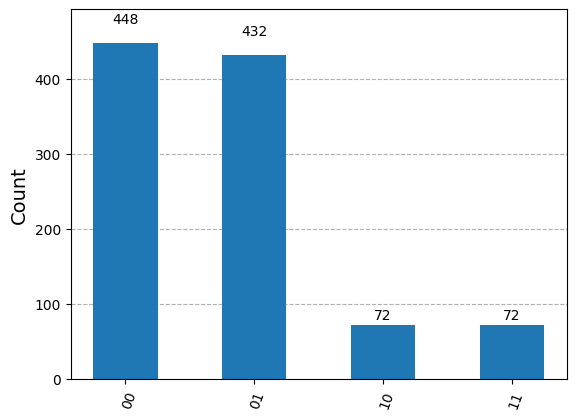

In [ ]:
nb_anc = 2

stats = simulate_circuit_histogram(QPE(nb_anc), range(nb_anc)[::-1])
plot_histogram(stats)

-----

## Algorithme 4 - BONUS pour le fun : Résolution de système linéaire avec HHL
